# **Introducción al Machine Learning**
# ML_AE-16 - Introducción a métodos de clustering


En este notebook  utilizaremos los datos del dataset de entrenamiento del Titanic (_titanic_train.csv_) para introducir el concepto de __clustering__.


Como punto de partida importaremos nuestras 4 librerías.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## <font color='blue'>**Leyendo los datos**</font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_file = '/content/drive/MyDrive/MODULO 8 - INTRODUCCION ML/titanic_train.csv'
train_df = pd.read_csv(path_file)

## <font color='blue'>**Breve análisis exploratorio de los datos**</font>

La siguiente, es el diccionario de datos del archivo:

1. Survival: Sobreviviente		0 = No, 1 = Si
2. Pclass: La clase del ticket	1 = 1st, 2 = 2nd, 3 = 3rd
3. Sex:	Sexo
4. Age: Edad en años
5. Sibsp:	Número de hermanas / cónyuges a bordo del Titanic
6. Parch:	Número de padres / hijos a bordo del Titanic
7. Ticket:	Número del ticket
8. Fare:	Tarifa de pasajero
9. Cabin: Número de cabina
10. Embarked: Puerto de embarque	C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train_df.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000,257.354,1.00,223.500,446.000,668.5,891.000
Survived,891.0,0.384,0.487,0.00,0.000,0.000,1.0,1.000
Pclass,891.0,2.309,0.836,1.00,2.000,3.000,3.0,3.000
Age,714.0,29.699,14.526,0.42,20.125,28.000,38.0,80.000
SibSp,891.0,0.523,1.103,0.00,0.000,0.000,1.0,8.000
Parch,891.0,0.382,0.806,0.00,0.000,0.000,0.0,6.000
Fare,891.0,32.204,49.693,0.00,7.910,14.454,31.0,512.329


Qué puede decir de los distintos atributos? Cómo es la media y la mediana? Existe mucha diferencia entre ellas en algunas variables, por ejemplo **Survived**? Qué significa eso?

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### __Análisis categórico__

Aplicamos `sns.countplot` a la variable __Survival__, y luego a las variables __Sex__, __Embarked__, __Pclass__, y __Age__ diferenciándolas (_hue_) por la variable __Survived__.


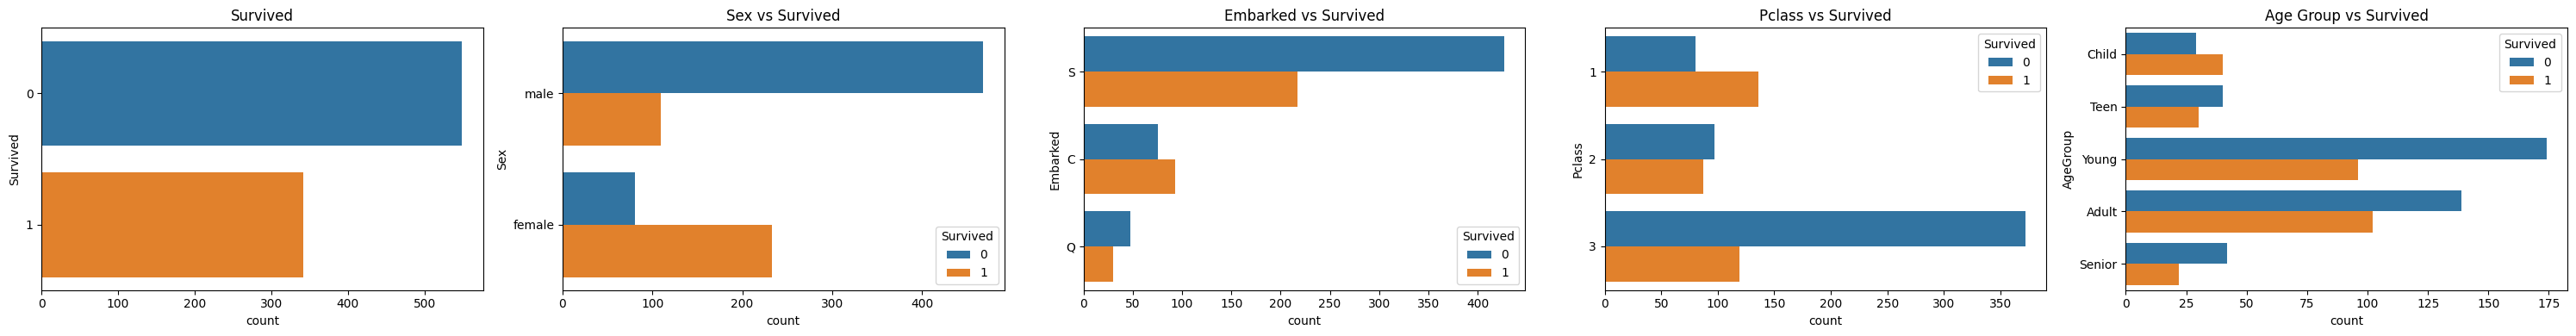

In [ ]:
c_palette = ['tab:blue', 'tab:orange']

# Crear una nueva columna con edades agrupadas
train_df['AgeGroup'] = pd.cut(train_df['Age'], bins=[0, 12, 18, 30, 50, 80],
                              labels=['Child', 'Teen', 'Young', 'Adult', 'Senior'])

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30, 4))

sns.countplot(y='Survived', hue='Survived', data=train_df, ax=axes[0], palette=c_palette, legend=False)
sns.countplot(y='Sex', hue='Survived', data=train_df, ax=axes[1], palette=c_palette)
sns.countplot(y='Embarked', hue='Survived', data=train_df, ax=axes[2], palette=c_palette)
sns.countplot(y='Pclass', hue='Survived', data=train_df, ax=axes[3], palette=c_palette)
sns.countplot(y='AgeGroup', hue='Survived', data=train_df, ax=axes[4], palette=c_palette)

axes[0].set_title('Survived')
axes[1].set_title('Sex vs Survived')
axes[2].set_title('Embarked vs Survived')
axes[3].set_title('Pclass vs Survived')
axes[4].set_title('Age Group vs Survived')

plt.tight_layout()
plt.show()

En proporción sobrevivieron más mujeres que hombres. Sin embargo, es interesante explorar si esto se mantuvo bajo otras condiciones como se producen variaciones en función del puerto de embarque y de la clase en que viajaban.

### __Análisis cuantitativo__

En esta sección se realizará un análisis exploratorio de variables seleccionadas del conjunto de datos.
Primero, se analizará la distribución de la variable __Age__ mediante una combinación de `boxplot` y `swarmplot`, permitiendo observar tanto la dispersión como la densidad de los valores individuales.
Posteriormente, se examinará la relación entre el número de padres o hijos a bordo (__Parch__) y la supervivencia (__Survived__) utilizando un `boxplot`, seguido de un análisis similar para el número de hermanos o cónyuges a bordo (__SibSp__).
También se analizará la relación entre el puerto de embarque (__Embarked__), la edad (__Age__) y la supervivencia, visualizando posibles diferencias entre grupos.
Finalmente, se incorporará la clase de cabina (__Pclass__) junto con el puerto de embarque (__Embarked__) para evaluar si existen patrones conjuntos relacionados con la edad.

Este análisis permitirá identificar tendencias relevantes en el comportamiento de las variables, diferencias en la distribución de la edad según factores demográficos y socioeconómicos, y establecer posibles hipótesis sobre su influencia en la supervivencia.

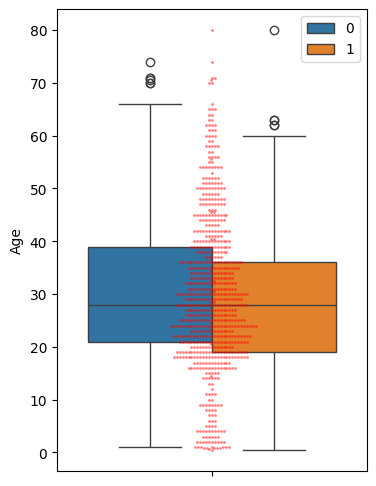

In [ ]:
# Analisis univariado de 'age'.
plt.figure(figsize=(4,6)) # Agrandamos la figura para hacerla más clara
sns.boxplot(y='Age', data=train_df, hue='Survived', palette=c_palette)
sns.swarmplot(y='Age', data=train_df, color='r', alpha=0.5, size=2)
plt.show()

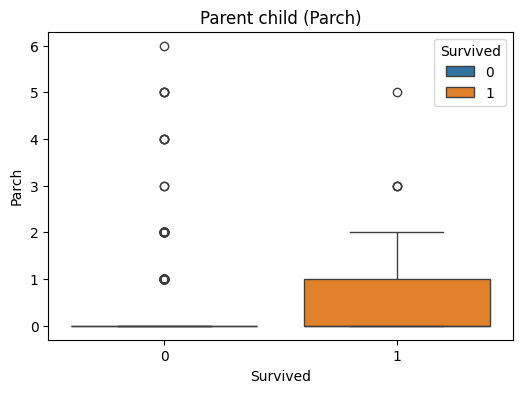

In [ ]:
# Variable Patch
plt.figure(figsize=(6,4))
sns.boxplot(x='Survived', y='Parch', data=train_df, hue='Survived', palette=c_palette).set(title='Parent child (Parch)')
plt.show()

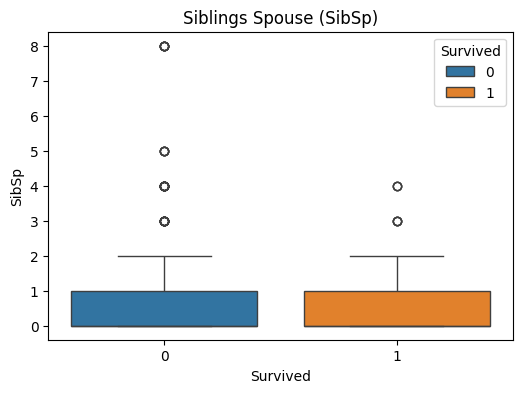

In [ ]:
# Variable SibSp
plt.figure(figsize=(6, 4))
sns.boxplot(x='Survived', y='SibSp', data=train_df, hue='Survived', palette=c_palette).set(title='Siblings Spouse (SibSp)')
plt.show()

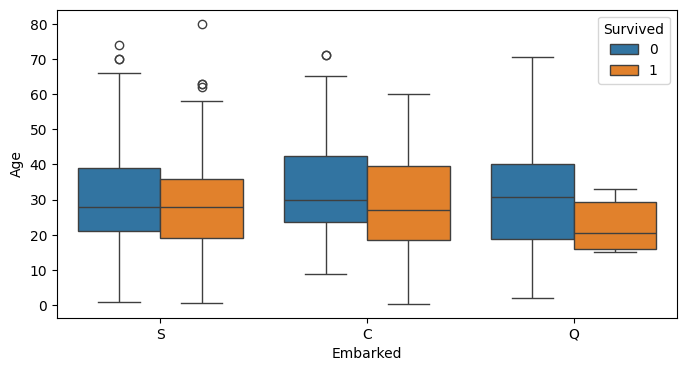

In [ ]:
# Analicemos la relación entre Embarked, Age y Survived.
plt.figure(figsize=(8,4))
sns.boxplot(x='Embarked', y='Age', hue='Survived',
            data=train_df, palette=c_palette)
plt.show()

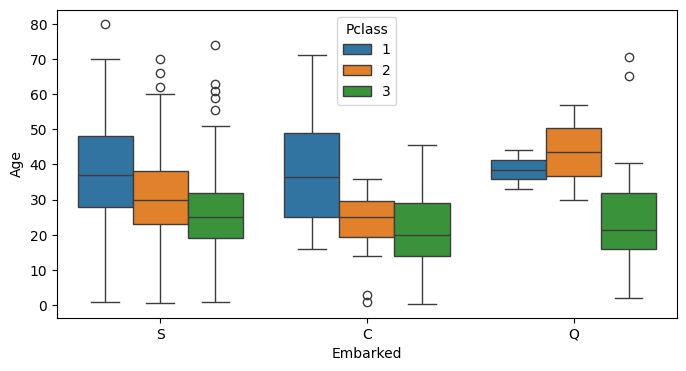

In [ ]:
# Incoporemos la clase y el embarque para ver si existe relación
# entre la edad y estas variables.
c_palette3 = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize=(8, 4))
sns.boxplot(x='Embarked', y='Age', hue='Pclass',
            data=train_df, palette=c_palette3)
plt.show()

### __Análisis de correlación__

La __correlación de Pearson__ mide la relación lineal entre dos variables numéricas. Sus valores se encuentran en el rango $[-1, 1]$, donde un valor de 1 indica una correlación lineal positiva perfecta, y un valor de -1 indica una correlación lineal negativa perfecta. Un valor cercano a 0 sugiere que no existe relación lineal entre las variables.

En esta sección, se construirá un nuevo dataframe que excluya las variables categóricas. Luego, se verificará la presencia de valores nulos (NaN) y, en caso de ser necesario, se imputarán los datos faltantes. Posteriormente, se visualizará la matriz de correlación utilizando un heatmap, aplicando el método de Pearson para calcular los coeficientes de correlación.

Se considerará la siguiente escala para interpretar la fuerza de la asociación:

|Valor|Fuerza de la asociación|
|:---:|:----------------------|
|0    |Asociación nula        |
|0.1  |Asociación pequeña     |
|0.3  |Asociación mediana     |
|0.5  |Asociación moderada    |
|0.7  |Asociación alta        |
|0.9  |Asociación muy alta    |


In [ ]:
# Eliminamos las variables categoricas
corr_df = train_df.drop(['PassengerId', 'Survived', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'AgeGroup'], axis = 1)
corr_df

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500
...,...,...,...,...,...
886,2,27.0,0,0,13.0000
887,1,19.0,0,0,30.0000
888,3,NaN,1,2,23.4500
889,1,26.0,0,0,30.0000


In [ ]:
# Chequeamos si hay elementos nulos
corr_df.isnull().values.any()

np.True_

In [ ]:
# Hay !!
# Veamos con info() donde están los nulos
corr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  891 non-null    int64  
 1   Age     714 non-null    float64
 2   SibSp   891 non-null    int64  
 3   Parch   891 non-null    int64  
 4   Fare    891 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 34.9 KB


In [ ]:
# Hay NaN en la columna 'age'. los rellenamos con la moda
corr_df['Age'] = corr_df['Age'].fillna(value=corr_df['Age'].mode()[0])
corr_df['Age']

,Age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0
...,...
886,27.0
887,19.0
888,24.0
889,26.0


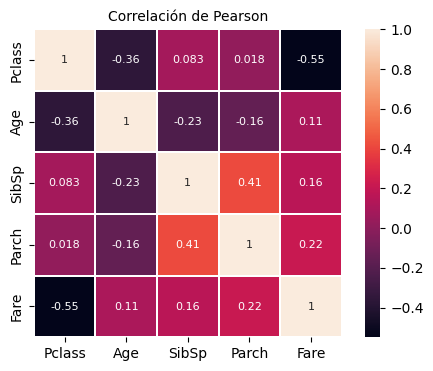

In [ ]:
# Correlación de Pearson en heatmap
plt.figure(figsize=(6,4))
plt.title('Correlación de Pearson', size = 10)
colormap = sns.diverging_palette(10, 220, as_cmap = True)
sns.heatmap(corr_df.corr(),
            square = True,
            annot = True,
            linewidths=0.1,vmax=1.0, linecolor='white',
            annot_kws={'fontsize':8 })
plt.show()

## <font color='blue'>**Clustering**</font>

En ocasiones, la relación entre una variable dependiente y un conjunto de variables independientes no es del todo evidente. En el análisis exploratorio anterior, observamos que la sobrevivencia de un pasajero estaba relacionada con algunas de las variables del conjunto de datos. Sin embargo, podemos profundizar aún más en este análisis. ¿Es posible identificar una relación más compleja y no evidente —de carácter multivariado— entre varias variables independientes y una variable objetivo como Survived? Para abordar esta pregunta, avanzaremos aplicando técnicas básicas de clustering que nos permitirán descubrir patrones ocultos en los datos.

### ¿Qué es el clustering?

Clustering es una técnica de aprendizaje no supervisado que consiste en agrupar observaciones en subconjuntos o “clusters” de manera que los elementos dentro de un mismo grupo sean más similares entre sí que respecto de los elementos de otros grupos.

## <font color='blue'>**K Means clustering**</font>

### La intuición
K-Means es un método de agrupamiento cuyo objetivo es particionar un conjunto de $N$ observaciones en $k$ grupos (o clusters), de manera que cada observación pertenezca al grupo cuyo centroide —el valor medio de las observaciones del grupo— sea el más cercano. Generalmente, se utiliza la distancia euclidiana (cuadrática) como medida de proximidad.

Consideremos un conjunto de datos de $N$ individuos, donde cada uno está representado por un vector de $M$ dimensiones que describe $M$ características distintas. Por ejemplo, cada vector podría representar un hogar individual, incluyendo atributos como ingreso, número de automóviles, número de hijos, entre otros.

El algoritmo de K-Means sigue los siguientes pasos:
1.	Inicialización: dado un número de grupos $k$, se establecen $k$ centroides en el espacio de los datos, por ejemplo, seleccionándolos aleatoriamente.
2.	Asignación de objetos a centroides: cada observación se asigna al centroide más cercano según la distancia definida.
3.	Actualización de centroides: se recalculan las posiciones de los centroides como el promedio de todas las observaciones asignadas a cada grupo.

Los pasos 2 y 3 se repiten iterativamente hasta que los centroides dejan de moverse o los movimientos son menores a un umbral predefinido.


<img src="https://drive.google.com/uc?export=view&id=1vGANhhd8DrllEQIyLFdLBDEqTCSvtOKD" width="1200">

### Ventajas y desventajas

K-Means es uno de los métodos de clustering más utilizados debido a su simplicidad y eficiencia computacional. Sin embargo, presenta varias limitaciones que deben considerarse:
- Requiere definir previamente el número de clusters ($k$). Esto puede ser desafiante si no se dispone de información adicional sobre la estructura de los datos. Existen métodos orientativos como la técnica del codo (elbow method) o la silhouette score para estimar $k$, pero no garantizan una respuesta única.
- Tiene dificultades para detectar clusters de formas no circulares o alargadas, ya que asume implícitamente que los grupos son esféricos y de tamaño similar.
- La calidad del agrupamiento puede depender de la inicialización aleatoria de los centroides. Para reducir esta sensibilidad, se recomienda ejecutar el algoritmo múltiples veces (por ejemplo, entre 25 y 50 repeticiones) y seleccionar el resultado con la menor suma de varianza interna. Además, solo se puede garantizar la reproducibilidad de los resultados si se fija una semilla aleatoria.
- Es sensible a la presencia de outliers, ya que estos pueden desplazar significativamente los centroides. Para mitigar este problema, se puede considerar eliminar los outliers antes del análisis o emplear métodos más robustos como K-Medoids (PAM).


In [ ]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

Utilizaremos la técnica K-means para identificar a partir del conjunto de variables del dataset si un pasajero sobrevive o no.

La tecnica K-means funciona en forma adecuada con variables idealmente continuas, por lo tanto vamos a eliminar las variables: ```['PassengerId', 'Cabin', 'Name', 'Ticket']```

Por otro lado k-means exige que cada celda tenga un valor numérico. Es por eso que en el caso de valores en blanco de `Age` o `Embarked` utilizaremos la moda. Y en el caso de `Sex` tenemos que convertirlo a numérico.

In [ ]:
def Procesamiento(dataframe):
    le = LabelEncoder()
    X = dataframe.drop(['PassengerId', 'Cabin', 'Name', 'Ticket', 'AgeGroup'], axis=1)
    X['Age'] = X['Age'].fillna(value=X['Age'].mode()[0])
    X['Embarked'] = le.fit_transform(X['Embarked'].fillna(value=X['Embarked'].mode()[0]))
    X['Sex'] = np.where(X['Sex'] == 'male', 1, 0)
    return X

## <font color='purple'> __EXPERIMENTO__: </font>
### En este análisis, buscamos experimentar con la posibilidad de que la empresa de venta de boletos del Titanic haya percibido una segmentación natural de sus clientes, lo cual nos lleva a explorar cómo se distribuyen los pasajeros en grupos basados únicamente en dos características: su edad y la tarifa que pagaron. Para ello, utilizamos el algoritmo de K-Means, sin recurrir a etiquetas o supervisión, con el objetivo de descubrir patrones ocultos dentro de los datos. En este caso, esperamos encontrar agrupaciones como, por ejemplo:

###Pasajeros jóvenes que pagaron tarifas más bajas.
###Pasajeros mayores que pagaron tarifas más altas.

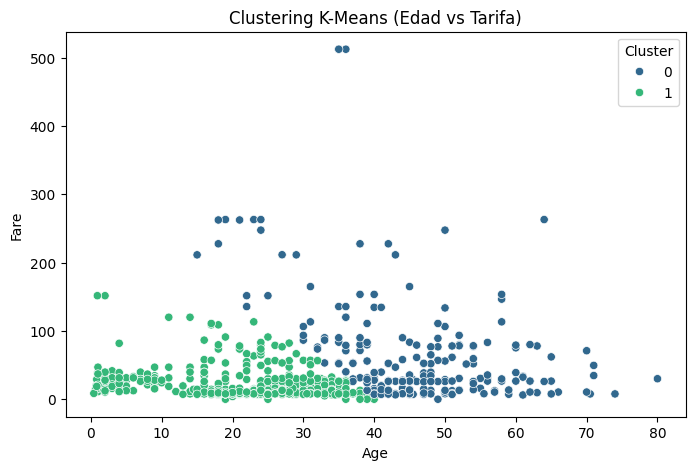

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Usamos solo algunas columnas numéricas que ya están limpias
df = train_df[['Age', 'Fare']].copy()

# Eliminamos filas con valores nulos
df.dropna(inplace=True)

# Escalamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Aplicamos KMeans con 2 clústeres
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualizamos
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Age', y='Fare', hue='Cluster', data=df, palette='viridis')
plt.title('Clustering K-Means (Edad vs Tarifa)')
plt.show()

###Al observar los resultados vemos que loa pasajeros jóvenes (grupo 0) pagaron tarifas más bajas, por lo cual lo cual podría representar pasajeros de tercera clase o de tarifas más económicas, mientras que, los pasajeros de mayor edad (grupo 1) podrían estar en primera clase o tarifas de mayor valor.

### <font color='purple'>Fin experimento </font>


# <font color='red'>__LINK DE INTERÉS__: Técnicas de clustering.</font>

El siguiente proporciona una guía completa sobre técnicas de clustering, con ejemplos y métricas. [aquí](https://scikit-learn.org/stable/modules/clustering.html)

## <font color='green'>**Actividad 1**</font>

Analice la función `Procesamiento`. Particularmente investigue que rol cumple LabelEncoder aplicado a la variable Embarked. Analice y compare esra función con la función de `pandas` `get_dummies`.

¿Por qué es necesario realizar todo este preprocesamiento?

**Rol de LabelEncoder aplicado a la variable Embarked**

La función LabelEncoder transforma las categorías de la columna Embarked en valores numéricos. Por ejemplo:

Si la columna tiene valores categóricos como `['S', 'C', 'Q']`, LabelEncoder asigna números consecutivos:

$$S → 0$$
$$C → 1$$
$$Q → 2$$

Este enfoque es útil cuando las categorías necesitan ser representadas como números para algoritmos de ML que no aceptan datos categóricos directamente. Sin embargo, este método tiene una limitación importante: los números asignados implican un orden $(0 < 1 < 2)$, lo cual no es necesariamente cierto para variables categóricas nominales como Embarked.

**Comparación con `pandas.get_dummies`**

La función get_dummies en pandas transforma una columna categórica en variables dummy (o variables indicadoras), lo que resulta en una representación de tipo "one-hot encoding". Por ejemplo, si la columna Embarked tiene valores como `['S', 'C', 'Q']`, get_dummies generará tres nuevas columnas:

|Embarked_S|	Embarked_C|	Embarked_Q|
|----------|------------|-----------|
|    1     |     	0     |     0     |
|    0     |	    1     |   	0     |
|    0     |    	0   	|     1     |

Cada fila tendrá un valor 1 en la columna correspondiente a su categoría original y 0 en las demás. Esto elimina la implicancia de orden entre categorías y es generalmente preferido para variables categóricas nominales.

**Comparación:**

Ventajas de LabelEncoder:

* Es más simple y genera una única columna numérica en lugar de múltiples columnas.
* Es más eficiente en términos de memoria y almacenamiento.

Ventajas de get_dummies:

* Evita la implicancia de orden entre categorías, lo que es más apropiado para variables categóricas nominales.
* Es preferido en modelos que pueden interpretar múltiples columnas correctamente, como árboles de decisión y redes neuronales.

**¿Por qué es necesario realizar todo este preprocesamiento?**

El preprocesamiento es esencial para preparar los datos antes de utilizarlos en modelos de Machine Learning. Las razones específicas incluyen:

* **Manejo de valores faltantes:** Los modelos de ML no funcionan bien con valores nulos, por lo que estos deben ser imputados o eliminados.

* **Transformación de variables categóricas:** Muchos algoritmos de ML, como regresión logística o SVM, requieren que las variables sean numéricas. Por ello, las variables categóricas deben ser convertidas mediante técnicas como LabelEncoder o get_dummies.

* **Normalización de formatos:** Convertir variables categóricas en valores numéricos uniformes facilita el uso de algoritmos y mejora la interpretabilidad de los resultados.

* **Reducción de dimensiones:** Al eliminar columnas irrelevantes, se reduce la complejidad del modelo y se evita el uso de datos que no aportan valor al análisis.

* **Preparación para el modelo:**Cada paso asegura que los datos estén en un formato que los modelos puedan interpretar correctamente y que los resultados sean consistentes.

**Conclusión**

La función Procesamiento realiza tareas fundamentales para limpiar y transformar los datos en un formato adecuado para Machine Learning. El uso de LabelEncoder es eficiente, pero puede ser problemático si las categorías no tienen un orden inherente. `pandas.get_dummies` sería una alternativa más robusta para la mayoría de los casos. El preprocesamiento es crucial para garantizar que los modelos funcionen correctamente y produzcan resultados confiables.

<font color='green'>Fin Actividad 1</font>

In [ ]:
# Se eliminan las columnas que no resultan útiles para aplicar K-Means
X = train_df.drop(['PassengerId', 'Cabin', 'Name', 'Ticket', 'AgeGroup'], axis=1)
X

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [ ]:
# Observamos que 'Age' tiene NaN, los completamos con la moda
X['Age'] = X['Age'].fillna(value=X['Age'].mode()[0])
# 'Embarked' es una variable categórica, la codificamos como numérica
# y completamos los NaN (si es que los hay) con la moda
X['Embarked'] = LabelEncoder().fit_transform(X['Embarked'].fillna(value=X['Embarked'].mode()[0]))
# Por úñtimo, 'Sex' lo llevamos a númerica con valores 0 y 1
X['Sex'] = np.where(X['Sex'] == 'male', 1, 0)
X

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,2
887,1,1,0,19.0,0,0,30.0000,2
888,0,3,0,24.0,1,2,23.4500,2
889,1,1,1,26.0,0,0,30.0000,0


In [ ]:
# Aplicamos Procesamiento a nuestro dataframe y obtenemos uno nuevo
samples = Procesamiento(train_df)

In [ ]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 55.8 KB


Cuando se utiliza K-Means, es fundamental que las variables sean comparables entre sí, ya que el algoritmo se basa en medidas de distancia. Para lograrlo, es necesario normalizar las variables. Existen diversos métodos de normalización, pero los más utilizados son MinMaxScaler y StandardScaler.
- MinMaxScaler transforma cada valor de una variable de manera proporcional dentro de un rango parametrizable, típicamente entre [0,1] (configurable mediante el parámetro feature_range). Es recomendable como primera opción cuando se desea preservar la forma de la distribución original de los datos sin distorsionar su estructura interna.
- StandardScaler transforma cada variable para que tenga media cero y desviación estándar uno, es decir, cada valor se normaliza restando la media y dividiendo por la desviación estándar de la variable. Se recomienda utilizar StandardScaler si se sabe o se asume que la distribución de los datos es aproximadamente normal.

En este caso, para hacer comparables las variables, utilizaremos StandardScaler.

Adicionalmente, en K-Means es necesario definir el número inicial de clusters ($K$). Para seleccionar un valor adecuado de $K$, emplearemos una gráfica basada en una medida denominada Inertia.

La inercia mide qué tan bien se agrupan los datos dentro de sus respectivos clusters. Se calcula sumando las distancias cuadradas de cada observación a su centroide correspondiente. Un modelo adecuado presenta baja inercia y un número razonable de grupos ($K$). Sin embargo, existe una compensación: a medida que se incrementa el número de clusters, la inercia disminuye de manera natural, por lo que simplemente minimizar la inercia no garantiza la mejor elección de $K$.

Para encontrar el número óptimo de clusters, utilizaremos el método del codo (Elbow Method), que consiste en graficar la inercia en función de $K$ y localizar el punto donde la disminución de la inercia comienza a hacerse más lenta. Este punto, conocido como el “codo” de la curva, representa una elección razonable para el valor de $K$. Por ejemplo, si observamos que el codo se forma en $K=2$, ese sería el número sugerido de clusters para el modelo.

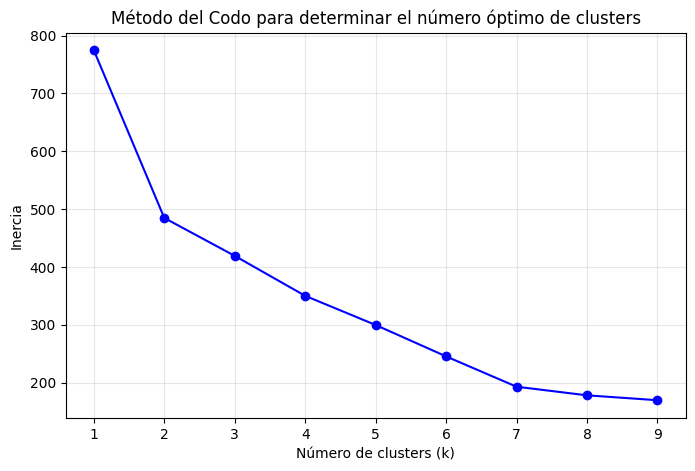

Inercia para k=9: 169.45


In [ ]:
scaler = preprocessing.MinMaxScaler()
samples_scaled = scaler.fit_transform(samples)

# Definimos el rango de k (número de clusters)
ks = range(1, 10)
inertias = []

# Aplicamos K-Means para diferentes valores de k y registramos las inercias
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(samples_scaled)
    inertias.append(kmeans.inertia_)

# Graficamos la inercia en función del número de clusters
plt.figure(figsize=(8, 5))
plt.plot(ks, inertias, '-o', color='blue')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar el número óptimo de clusters')
plt.xticks(ks)
plt.grid(alpha=0.3)
plt.show()

# Mostrar la inercia final como referencia
print(f'Inercia para k=9: {inertias[-1]:.2f}')

En el contexto del análisis de agrupamiento, se utilizó el método del codo para determinar el número óptimo de clusters. Este método consiste en identificar el punto donde se produce un cambio notable en la pendiente de la curva de inercia, generando la apariencia de un “codo”. En este caso particular, el codo se observa en $K=2$, lo que sugiere que dos clusters representan una segmentación adecuada de los datos. Esta elección también tiene sentido desde el punto de vista conceptual, ya que la variable objetivo que se busca modelar `Survived` tiene dos clases: sobrevivientes y no sobrevivientes.


Entonces, aplicaremos el algoritmo K-Means para agrupar a los pasajeros del Titanic en dos clusters, basándonos en un conjunto de variables numéricas procesadas. Para asegurar que todas las características sean comparables, primero escalaremos los datos utilizando MinMaxScaler. Posteriormente, dividiremos el conjunto de datos en subconjuntos de entrenamiento y validación, y ajustaremos un modelo de K-Means utilizando $K=2$ clusters, en coherencia con la existencia de dos clases principales en el problema: sobrevivientes y no sobrevivientes. Finalmente, evaluaremos el agrupamiento obtenido a través de la métrica de inercia, que mide la compacidad interna de los clusters formados.

In [ ]:
# Preprocesamos el conjunto de datos original
samples = Procesamiento(train_df)

# Definimos el escalador y el modelo de clustering
scaler = preprocessing.MinMaxScaler()
K = 2  # Número de clusters
k_mean = KMeans(n_clusters=K, random_state=42)

# Dividimos los datos en conjunto de entrenamiento y validación
sample_train, sample_val, gt_train, gt_val = train_test_split(
    samples,
    train_df['Survived'],
    test_size=0.2,
    random_state=99
)

# Construimos un pipeline que primero escala los datos y luego aplica K-Means
pipeline = make_pipeline(scaler, k_mean)

# Ajustamos el pipeline al conjunto de entrenamiento
pipeline.fit(sample_train)

# Predecimos los clusters en el conjunto de validación
labels = pipeline.predict(sample_val)

# Imprimimos la inercia final del modelo
print(f'Inercia de los clusters: {k_mean.inertia_:.2f}')

Inercia de los clusters: 382.94


## <font color='blue'>**Matriz de confusión**</font>

Una vez construido un modelo de clasificación, surge la necesidad de evaluar su desempeño de manera objetiva. Para ello, en problemas de clasificación supervisada, es fundamental el uso de la __Matriz de Confusión__.

En el ámbito del aprendizaje automático, la matriz de confusión es una herramienta que permite visualizar y cuantificar el rendimiento de un clasificador. Cada columna de la matriz representa el número de predicciones realizadas para cada clase, mientras que cada fila corresponde a las instancias verdaderas de cada clase. Uno de los beneficios principales de esta matriz es que facilita la identificación de patrones de error, mostrando específicamente si el modelo tiende a confundir ciertas clases.



<center><img src="https://drive.google.com/uc?export=view&id=11X8idteIBlAntMOeZCTFnfSMgnzLEa0V" width="600" title="Confision Matrix"></center>

Los elementos de la matriz se interpretan de la siguiente manera:
- Verdaderos positivos (TP): Casos en los que el modelo predijo 1 y el valor real es efectivamente 1.
- Verdaderos negativos (TN): Casos en los que el modelo predijo 0 y el valor real es 0.
- Falsos positivos (FP): Casos en los que el modelo predijo 1, pero el valor real era 0. Este error se conoce como error tipo I.
- Falsos negativos (FN): Casos en los que el modelo predijo 0, pero el valor real era 1. Este error se denomina error tipo II.



A partir de la matriz de confusión se definen varios indicadores clave de desempeño:
1.	Recall (Sensibilidad o Tasa de Verdaderos Positivos):
Mide, de todas las instancias realmente positivas, cuántas fueron correctamente identificadas por el modelo. Se busca que este valor sea lo más alto posible.

$$ \text{Recall} = \frac{TP}{TP + FN} $$
<br>
2.	Precisión (Precision):
Mide, de todas las instancias que el modelo predijo como positivas, cuántas realmente lo son. Una alta precisión indica pocos falsos positivos.

$$ \text{Precision} = \frac{TP}{TP + FP} $$
<br>
3.	Exactitud (Accuracy):
Mide la proporción de predicciones correctas (tanto positivas como negativas) sobre el total de casos evaluados. Es una medida general del desempeño del modelo.

$$ \text{Accuracy} = \frac{TP + TN}{P + N} $$
<br>



<center><img src="https://drive.google.com/uc?export=view&id=16wM132gIy9taOOA3UrEodtzYIEliBb3P" width="400" title="Precision-Recall"></center>


4.	F-Score (o F1-Score):
En situaciones donde es difícil decidir entre priorizar la precisión o el recall, se utiliza el F-Score, que combina ambas métricas en un solo valor mediante su media armónica. Esto penaliza de manera más severa los valores extremos, proporcionando una evaluación equilibrada del modelo.

$$ F\text{-}Score = \frac{2 \times \text{Recall} \times \text{Precision}}{\text{Recall} + \text{Precision}} $$

El F-Score resulta particularmente útil cuando existe un desbalance entre las clases, ya que proporciona una visión más justa del desempeño del clasificador.






In [ ]:
ct_df = pd.DataFrame({'labels': labels, 'survived': gt_val})
# create crosstb
ct = pd.crosstab(ct_df['labels'], ct_df['survived'])
print(ct)

survived    0   1
labels           
0         112   9
1           1  57


El siguiente código utiliza la función `confusion_matrix` de `sklearn` para comparar las etiquetas verdaderas (`gt_val`) con las etiquetas predichas (`labels`) y construir una matriz de confusión. Esta matriz permite visualizar el desempeño del modelo clasificando ejemplos como positivos o negativos.

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(gt_val, labels)
cm

array([[112,   1],
       [  9,  57]])

Los resultados se interpretan de la siguiente manera:
se interpreta de la siguiente manera:
- 112: Verdaderos negativos (predijo correctamente que no sobrevivieron).
- 1: Falsos positivos (predijo que sobrevivieron, pero no lo hicieron).
- 9: Falsos negativos (predijo que no sobrevivieron, pero sí sobrevivieron).
- 57: Verdaderos positivos (predijo correctamente que sobrevivieron).

Esta matriz es fundamental para calcular métricas de evaluación como accuracy, precision, recall y F1-score.

El siguiente código utiliza classification_report de sklearn para generar un resumen detallado de las métricas de desempeño del modelo, basándose en la comparación entre las etiquetas verdaderas (gt_val) y las etiquetas predichas (labels).

El reporte incluye, para cada clase:
- Precision: qué porcentaje de los elementos clasificados como positivos realmente son positivos.
- Recall: qué porcentaje de los elementos positivos fueron correctamente identificados.
- F1-Score: la media armónica entre precisión y recall, que equilibra ambas métricas.
- Support: la cantidad real de muestras de cada clase en el conjunto de datos.

Este resumen proporciona una visión clara y rápida de cuán bien el modelo está clasificando cada categoría, permitiendo detectar posibles desbalances o deficiencias en el desempeño.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(gt_val, labels))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       113
           1       0.98      0.86      0.92        66

    accuracy                           0.94       179
   macro avg       0.95      0.93      0.94       179
weighted avg       0.95      0.94      0.94       179



### Consejos generales sobre la matriz de confusión y sus métricas
1.	__Precisión:__
La precisión es una excelente métrica para evaluar modelos, pero resulta verdaderamente útil únicamente cuando se trabaja con conjuntos de datos balanceados, es decir, cuando las clases (por ejemplo, sobrevivientes y no sobrevivientes) tienen proporciones similares.

2.	__F1-Score:__
El F1-Score es más adecuado cuando existe desbalance en las clases, ya que combina en un solo valor la precisión y la sensibilidad (recall), proporcionando una medida equilibrada del desempeño.

3.	¿Cuándo __priorizar precisión o recall__?
- Elija una mayor precisión si le interesa saber qué tan seguro está de que las predicciones positivas realmente lo son.
- Elija una mayor sensibilidad (recall) si su prioridad es no perder ningún caso positivo, es decir, detectar la mayor cantidad posible de verdaderos positivos.

4.	En casos donde los __falsos negativos son inaceptables__:
Si su problema tolera algunos falsos positivos, pero no puede permitirse falsos negativos, debe priorizar una alta sensibilidad (recall).
Ejemplo: en un sistema de diagnóstico de diabetes, es preferible clasificar a algunas personas sanas como enfermas que dejar sin diagnóstico a una persona que realmente sea diabética.

5.	En casos donde los __falsos positivos son más problemáticos__:
Cuando el costo de los falsos positivos es alto, debe priorizar la precisión.
Ejemplo: en el filtrado de correos electrónicos, es preferible recibir algunos correos no deseados en la bandeja de entrada, antes que perder correos legítimos enviándolos a la carpeta de spam.

6.	__Alta especificidad__:
Cuando es fundamental evitar falsos positivos, se debe buscar una alta especificidad (es decir, una alta tasa de verdaderos negativos).
Ejemplo: en controles de alcoholemia o pruebas de drogas donde un resultado positivo implica consecuencias severas (como ir a prisión), es crucial evitar que una persona inocente sea clasificada erróneamente como positiva.

$$
\text{Specificity} = \frac{TN}{TN + FP}
$$

Especificidad es otra métrica derivada de la matriz de confusión, y sí, es el “complemento” del Recall pero aplicado a la clase negativa.


## <font color='blue'>**DBSCAN**</font>

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo de agrupamiento no supervisado que identifica clusters basándose en la densidad de los puntos en el espacio de características.
A diferencia de otros métodos como K-Means, DBSCAN no requiere predefinir el número de clusters y tiene la capacidad de detectar automáticamente grupos de diferentes formas y tamaños, así como identificar outliers (puntos de ruido que no pertenecen a ningún cluster).

El algoritmo funciona estableciendo dos parámetros principales:
- `eps` (epsilon): la distancia máxima entre dos puntos para que se consideren vecinos.
- `min_samples`: el número mínimo de puntos necesarios para formar una región densa.

Basándose en estos parámetros, DBSCAN clasifica cada punto de datos como:
- Punto central (core point): si tiene al menos min_samples vecinos dentro de la distancia eps.
- Punto de borde (border point): si está dentro de eps de un punto central, pero no alcanza min_samples por sí mismo.
- Outlier o ruido: si no cumple ninguna de las condiciones anteriores.
<br><br>
<img src='https://drive.google.com/uc?export=view&id=1YixvS9xtoOdKzzyaKrItHlqBA3T5S6bn' width="500" align="center" style="margin-right: 20px">

DBSCAN es especialmente útil cuando:
- Se desea encontrar agrupamientos de formas irregulares.
- Se quiere detectar anomalías o outliers naturalmente durante el proceso de clustering.
- No se conoce de antemano cuántos clusters hay en los datos.

Acá puedes ver una visualización animada del algoritmo de [DBSCAN](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/).

Aplicaremos DBSCAN sobre un conjunto de datos esféricos (similar al usado en k-means).

Número de clusters: 3.000
Homogeneity: 0.982
Completeness: 0.938
Mean Silhouette score: 0.680


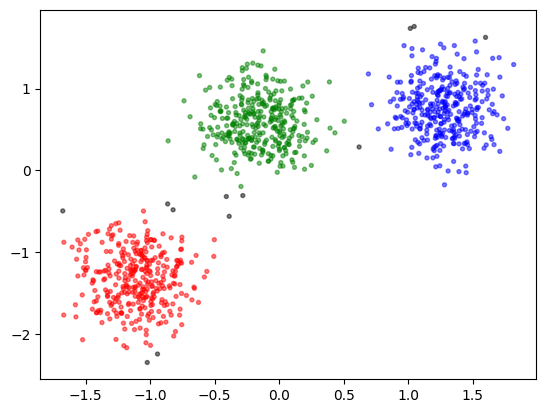

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# Generación de la data
X, y = make_blobs(n_samples=1000,
                  n_features=2,
                  centers=3,
                  random_state=170)

colors = np.array(['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'yellow', 'magenta', 'brown', 'gray', 'black'])

# Normalización de las variables
X = StandardScaler().fit_transform(X)

# Entrenar DBSCAN
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(X)

# Graficar las predicciones
plt.scatter(X[:,0], X[:,1], c=colors[y_pred], alpha=0.5, s=8)

# Imprimir los resultados
print(f'Número de clusters: {len(set(y_pred[np.where(y_pred != -1)])):5.3f}')
print(f'Homogeneity: {metrics.homogeneity_score(y, y_pred):5.3f}')
print(f'Completeness: {metrics.completeness_score(y, y_pred):5.3f}')
print(f'Mean Silhouette score: {metrics.silhouette_score(X, y_pred):5.3f}')

Los **puntos negros** corresponden a los **outliers** para el resultado anterior.

Ten en cuenta que **no es necesario especificar el número de clústeres** con el algoritmo DBSCAN. Además, DBSCAN es bueno para descubrir los valores atípicos sin requerir algunos trucos como lo hicimos anteriormente para el algoritmo de k-means.

Sin embargo DBSCAN no siempre funciona bien, por ejemplo aumentemos el número de puntos que definen nuestro conjunto de prueba (hasta 5000 como el usado para el ejemplo de k-means).

Número de clusters: 2
Homogeneity: 0.578
Completeness: 0.988
Mean Silhouette score: 0.579


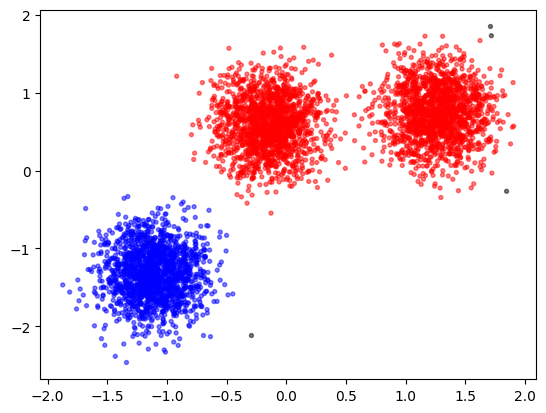

In [ ]:
# Generación de la data
X, y = make_blobs(n_samples=5000,
                  n_features=2,
                  centers=3,
                  random_state=170)

# Normalización de las variables
X = StandardScaler().fit_transform(X)

# Entrenar DBSCAN
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(X)

# Graficar las predicciones
plt.scatter(X[:,0], X[:,1], c=colors[y_pred], alpha=0.5, s=8)

# Imprimir los resultados
print(f'Número de clusters: {len(set(y_pred[np.where(y_pred != -1)]))}')
print(f'Homogeneity: {metrics.homogeneity_score(y, y_pred):5.3f}')
print(f'Completeness: {metrics.completeness_score(y, y_pred):5.3f}')
print(f'Mean Silhouette score: {metrics.silhouette_score(X, y_pred):5.3f}')

Podemos observar que DBSCAN solo logra determinar (en esta configuración de hiperparámetros del modelo) solo 2 clusters de los 3 que intuitivamente somos capaces de determinar.

Para solucionar este problema debemos trabajar con los hiperparámetros del modelo, en este caso **eps** y **min_samples** (MinPts).

Número de clusters: 3
Homogeneity: 0.984
Completeness: 0.944
Mean Silhouette score: 0.676


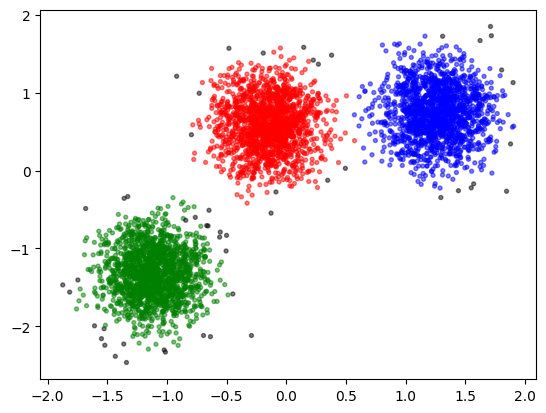

In [ ]:
# Generación de la data
X, y = make_blobs(n_samples=5000,
                  n_features=2,
                  centers=3,
                  random_state=170)

# Normalización de las variables
X = StandardScaler().fit_transform(X)

# Entrenar DBSCAN
y_pred = DBSCAN(eps=0.12, min_samples=5).fit_predict(X)

# Graficar las predicciones
plt.scatter(X[:,0], X[:,1], c=colors[y_pred], alpha=0.5, s=8)

# Imprimir los resultados
print(f'Número de clusters: {len(set(y_pred[np.where(y_pred != -1)]))}')
print(f'Homogeneity: {metrics.homogeneity_score(y, y_pred):5.3f}')
print(f'Completeness: {metrics.completeness_score(y, y_pred):5.3f}')
print(f'Mean Silhouette score: {metrics.silhouette_score(X, y_pred):5.3f}')

Con esta configuración de hiperparámetros es posible encontrar un resultado más cercano, en el cual es posible identificar los 3 clusters.

### DBSCAN con datasets más complejos
Otro ejemplo: Probemos DBSCAN con el dataset lunas que tantos problemas genera para el algoritmo k-Means.

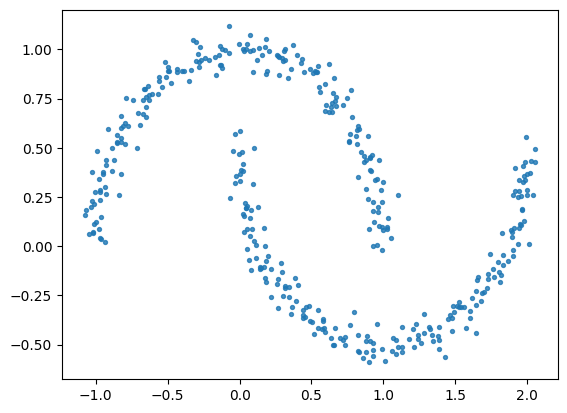

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=400, noise=0.05, random_state=0)
plt.scatter(X[:,0], X[:,1], alpha=0.8, s=8)
plt.show()

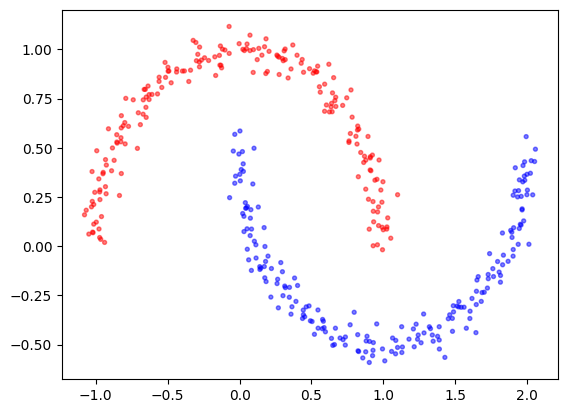

In [ ]:
model = DBSCAN(eps = 0.2)
clusters = model.fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=colors[clusters], alpha=0.5, s=8)
plt.show()

## <font color='green'>Actividad 2</font>

Considere el siguiente conjunto de datos no esféricos:

```
# Generación de data no esférica.
X, y = make_circles(n_samples=1000, factor=0.3, noise=0.1)
```

1. Implemente un modelo DBSCAN para agrupar sus datos (recuerde los pasos metoddológicos necesarios para implementar un buen modelo). Calcule las siguientes métricas: i) número de clusters, ii) homogeneidad, iii) completitud y iv) mean silhouette score.

2. Repita el proceso implementando un algoritmo k-means.

3. Grafique la salida de ambos modelos y comente sus resultados.

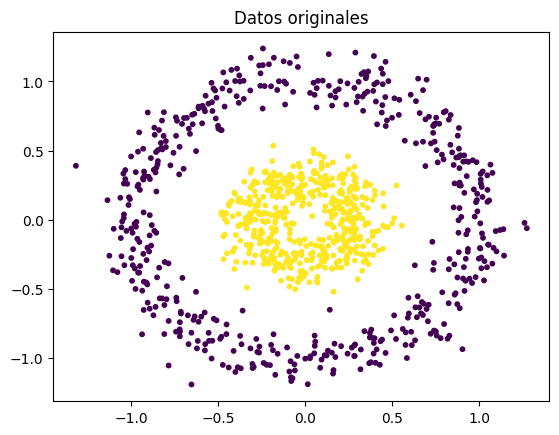

In [ ]:
from sklearn import metrics
from sklearn.datasets import make_circles

# Tu código aquí ...
# Generación de datos no esféricos
X, y = make_circles(n_samples=1000, factor=0.3, noise=0.1)

# Visualización de los datos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=10)
plt.title("Datos originales")
plt.show()




DBSCAN:
Número de clusters: 2
Homogeneidad: 0.99
Completitud: 0.96
Silhouette Score: 0.17


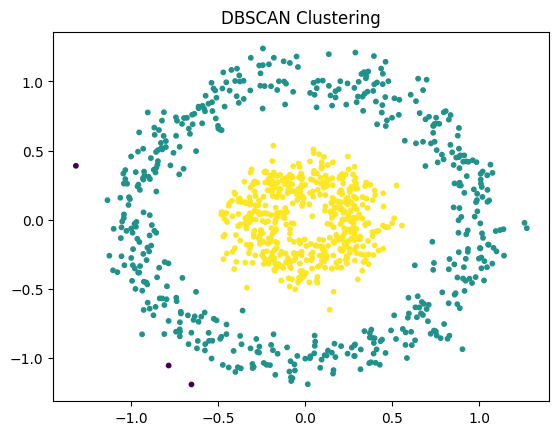

In [ ]:
# Escalamiento de los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Implementación de DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)  # Ajustar eps y min_samples según el análisis exploratorio
dbscan_labels = dbscan.fit_predict(X_scaled)

# Número de clusters (sin contar ruido)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

# Cálculo de métricas
homogeneity_dbscan = metrics.homogeneity_score(y, dbscan_labels)
completeness_dbscan = metrics.completeness_score(y, dbscan_labels)

# Filtrar etiquetas de ruido para silhouette score
silhouette_dbscan = metrics.silhouette_score(X_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

# Resultados de DBSCAN
print("DBSCAN:")
print(f"Número de clusters: {n_clusters_dbscan}")
print(f"Homogeneidad: {homogeneity_dbscan:.2f}")
print(f"Completitud: {completeness_dbscan:.2f}")
print(f"Silhouette Score: {silhouette_dbscan:.2f}")

# Visualización de clusters DBSCAN
plt.scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title("DBSCAN Clustering")
plt.show()

K-means:
Número de clusters: 2
Homogeneidad: 0.00
Completitud: 0.00
Silhouette Score: 0.29


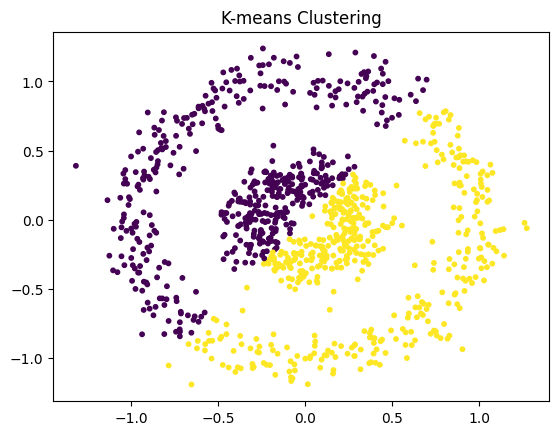

In [ ]:
# Implementación de k-means
kmeans = KMeans(n_clusters=2, random_state=42)  # Estimamos que hay 2 clusters por la estructura de los datos
kmeans_labels = kmeans.fit_predict(X_scaled)

# Número de clusters
n_clusters_kmeans = len(set(kmeans_labels))

# Cálculo de métricas
homogeneity_kmeans = metrics.homogeneity_score(y, kmeans_labels)
completeness_kmeans = metrics.completeness_score(y, kmeans_labels)
silhouette_kmeans = metrics.silhouette_score(X_scaled, kmeans_labels)

# Resultados de k-means
print("K-means:")
print(f"Número de clusters: {n_clusters_kmeans}")
print(f"Homogeneidad: {homogeneity_kmeans:.2f}")
print(f"Completitud: {completeness_kmeans:.2f}")
print(f"Silhouette Score: {silhouette_kmeans:.2f}")

# Visualización de clusters k-means
plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title("K-means Clustering")
plt.show()

<font color='green'>Fin Actividad 2</font>

### Hiperparámetros de DBSCAN

DBSCAN tiene algunos parámetros y de ellos, dos son cruciales: `eps` y `min_samples`.

Eps es la distancia más lejana a la que un punto seleccionará a sus vecinos. MinPts se refiere al número de puntos vecinos necesarios para que un punto se considere una región densa o un grupo válido. Por lo general, `min_samples` se establece en un valor que tenga sentido para el conjunto de datos y el número de dimensiones presentes. Esto determinará el número de valores atípicos identificados. Sin embargo, este parámetro no es tan crucial como eps.

**El parámetro más importante de DBSCAN es eps**. Como indicamos previamente es la distancia más lejana a la que un punto seleccionará a sus vecinos. Por tanto, esto decidirá intuitivamente cuántos vecinos descubrirá un punto. Esto dependerá de la distribución de los datos en sí.

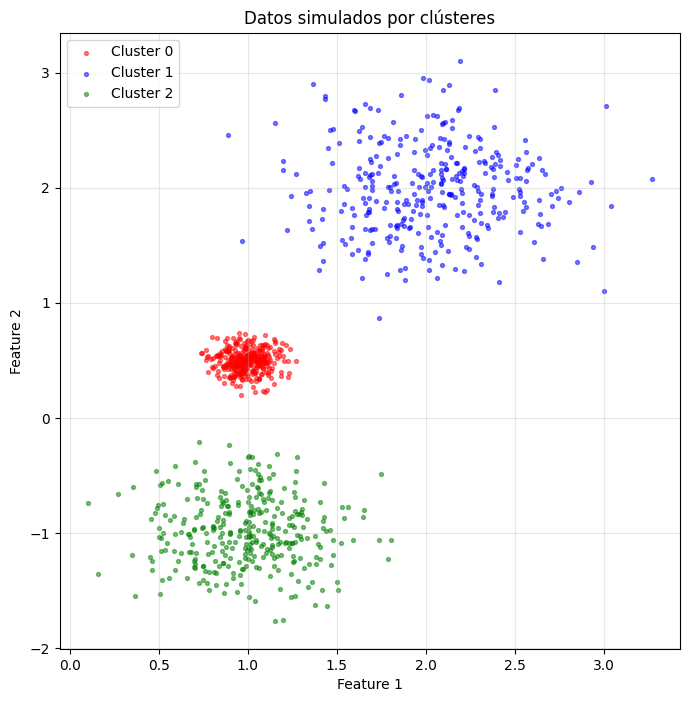

In [ ]:
# Generación de los datos
centers = [[1, 0.5], [2, 2], [1, -1]]
stds = [0.1, 0.4, 0.3]
X, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=stds, random_state=0)

# Crear el gráfico
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)

# Graficar cada grupo de datos
for cluster_id in np.unique(labels_true):
    mask = labels_true == cluster_id
    ax.scatter(X[mask, 0], X[mask, 1],
               c=colors[cluster_id],
               label=f'Cluster {cluster_id}',
               s=8, alpha=0.5)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('Datos simulados por clústeres')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

Hagamos DBSCAN con algunos valores para nuestro conjunto de datos.

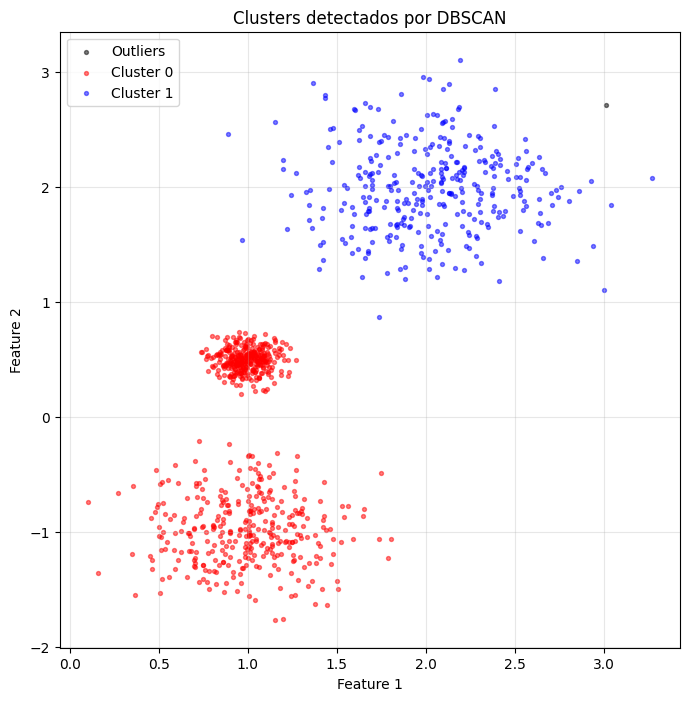

In [ ]:
# Ajustar modelo DBSCAN
db = DBSCAN(eps=0.5, min_samples=10).fit(X)
labels = db.labels_

# Crear el gráfico
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)

# Graficar cada cluster por separado
for cluster_id in np.unique(labels):
    mask = labels == cluster_id
    if cluster_id == -1:
        color = 'black'  # Color especial para los outliers
        label = 'Outliers'
    else:
        color = colors[cluster_id % len(colors)]  # Si hay más clusters que colores, rotamos
        label = f'Cluster {cluster_id}'

    ax.scatter(X[mask, 0], X[mask, 1],
               c=color,
               label=label,
               s=8, alpha=0.5)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('Clusters detectados por DBSCAN')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

Podemos ver claramente en nuestra última figura que dos grupos se han fusionado.Estas situaciones pueden producir problemas en una aplicación de agrupación en problemas reales.

Variaremos el valor de eps para ver su efecto sobre los clusters.

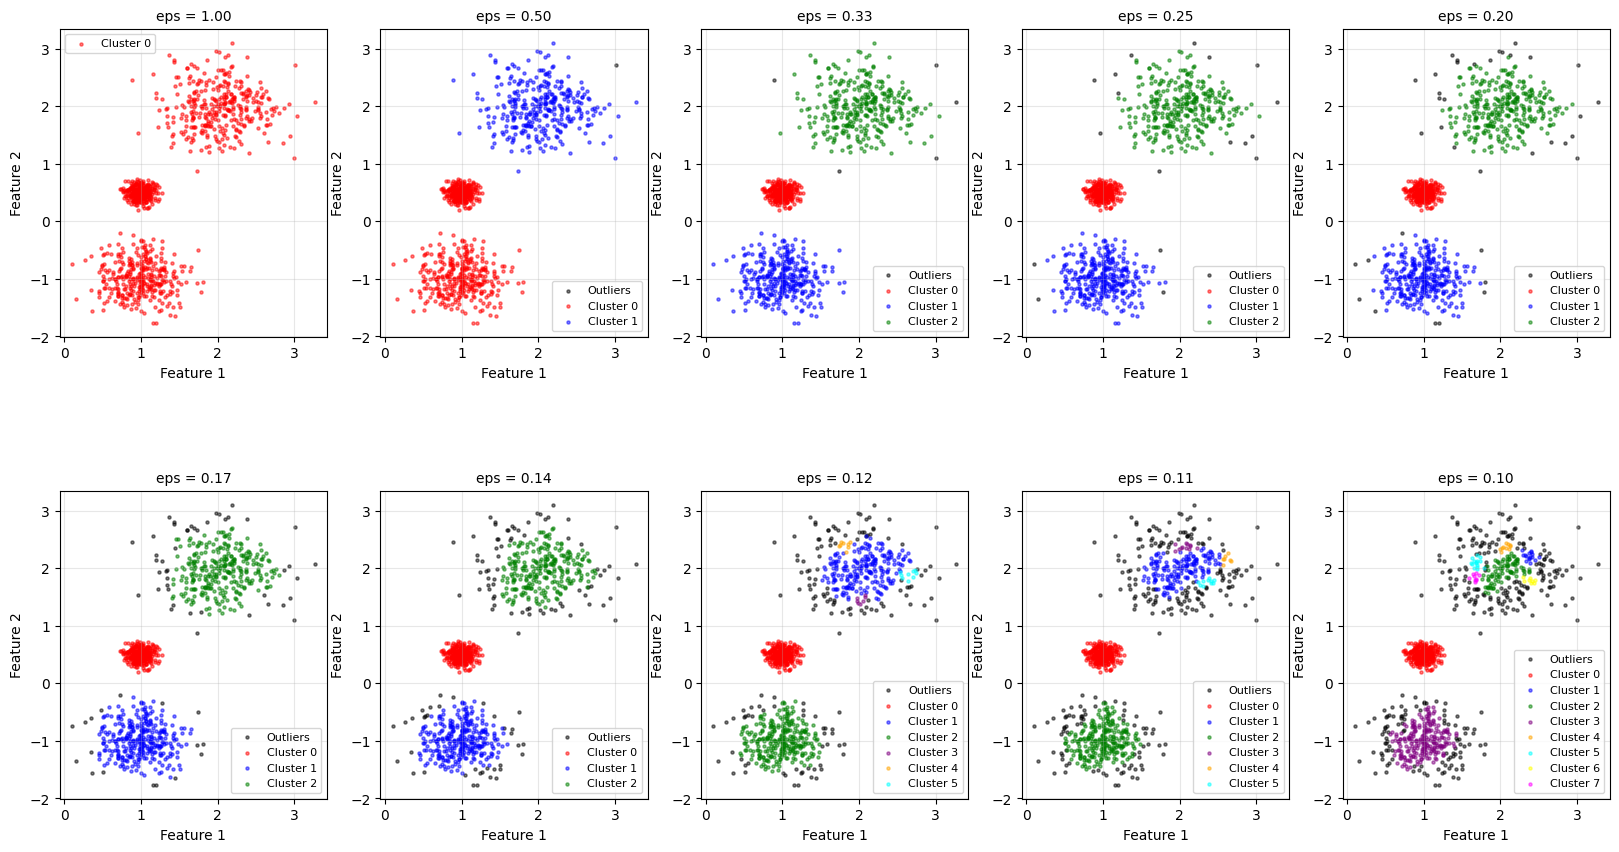

In [ ]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

i = 1
for x in range(10, 0, -1):
    eps = 1 / (11 - x)
    db = DBSCAN(eps=eps, min_samples=10).fit(X)
    labels = db.labels_

    ax = fig.add_subplot(2, 5, i)
    ax.set_title(f"eps = {eps:.2f}", fontsize=10)

    for cluster_id in np.unique(labels):
        mask = labels == cluster_id
        if cluster_id == -1:
            color = 'black'
            label = 'Outliers'
        else:
            color = colors[cluster_id % len(colors)]
            label = f'Cluster {cluster_id}'

        ax.scatter(X[mask, 0], X[mask, 1],
                   c=color,
                   label=label,
                   s=5, alpha=0.5)

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

    i += 1

plt.show()

Podemos ver que alcanzamos un punto óptimo entre eps = 0.14 y eps = 0.33. Los valores de eps más pequeños tienen demasiado ruido o valores atípicos (se muestran en color negro).

## <font color='blue'>**Método para el tuning del parámetro _eps_**</font>

Dado que el valor de `eps` es proporcional al número esperado de vecinos descubiertos, podemos usar los vecinos más cercanos (`kNN`) para encontrar una estimación buena para el `eps`. Calculemos los vecinos más cercanos.

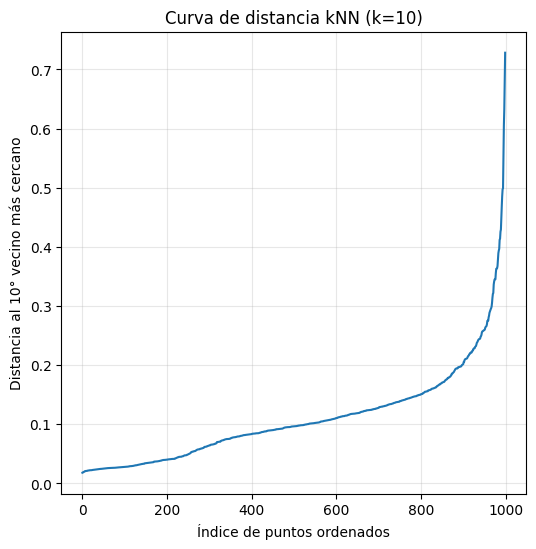

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Ajustar el modelo de vecinos más cercanos
# Solicitamos 11 vecinos porque el primer vecino siempre es el propio punto
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(X)

# Obtener distancias y los índices de los vecinos
distances, indices = neighbors.kneighbors(X)

# Nos interesa la distancia al 10° vecino real (no al propio punto)
distances = np.sort(distances[:, 10], axis=0)

# Crear la figura
fig = plt.figure(figsize=(6, 6))
plt.plot(distances)
plt.xlabel("Índice de puntos ordenados")
plt.ylabel("Distancia al 10° vecino más cercano")
plt.title("Curva de distancia kNN (k=10)")
plt.grid(alpha=0.3)
plt.show()

Al utilizar el método de los k vecinos más cercanos para estimar el parámetro `eps` en DBSCAN, es importante considerar que cada punto es su propio vecino más cercano. Por ello, al calcular los vecinos, se debe solicitar k+1 vecinos y luego analizar la distancia al k-ésimo vecino real. Posteriormente, ordenamos esas distancias de menor a mayor y graficamos la variación. El objetivo es identificar el punto de inflexión o “codo” de la curva, donde las distancias comienzan a crecer de forma más pronunciada. Ese punto sugiere un valor adecuado para eps. En el caso analizado, el codo se observa aproximadamente entre 0.1 y 0.3, un rango coherente con los valores de eps que también se exploraron gráficamente en el dataset.

Ville Satopaa et al. presentaron el paper “Finding a “Kneedle” in a Haystack: Detecting Knee Points in System Behavior” en el año 2011. En este artículo, se presenta una forma de detectar el punto de codo (elbow point).


In [ ]:
pip install kneed

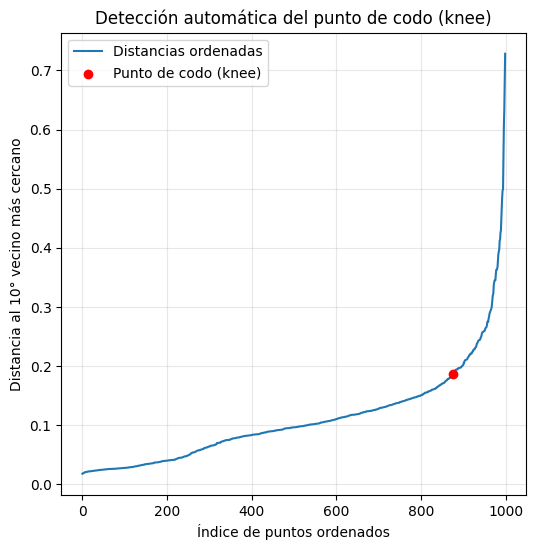


Distancia óptima sugerida (eps): 0.1872


In [ ]:
from kneed import KneeLocator

# Calcular el "knee point" automáticamente
i = np.arange(len(distances))
knee = KneeLocator(
    x=i,
    y=distances,
    S=1,                     # Sensibilidad del algoritmo (valor típico)
    curve='convex',           # Forma esperada de la curva
    direction='increasing',   # La curva crece
    interp_method='polynomial'  # Método de interpolación para suavizar
)

# Crear la figura
plt.figure(figsize=(6, 6))
plt.plot(i, distances, label='Distancias ordenadas')
plt.scatter(knee.knee, distances[knee.knee], color='red', label='Punto de codo (knee)', zorder=5)
plt.xlabel("Índice de puntos ordenados")
plt.ylabel("Distancia al 10° vecino más cercano")
plt.title("Detección automática del punto de codo (knee)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Imprimir la distancia correspondiente al knee detectado
print(f"\nDistancia óptima sugerida (eps): {distances[knee.knee]:.4f}")

Podemos ver que el punto de inflexión detectado por este método tiene un valor de 0.1603. Ahora podemos usar este valor como nuestro eps para ver cómo se vería nuestro nuevo agrupamiento.

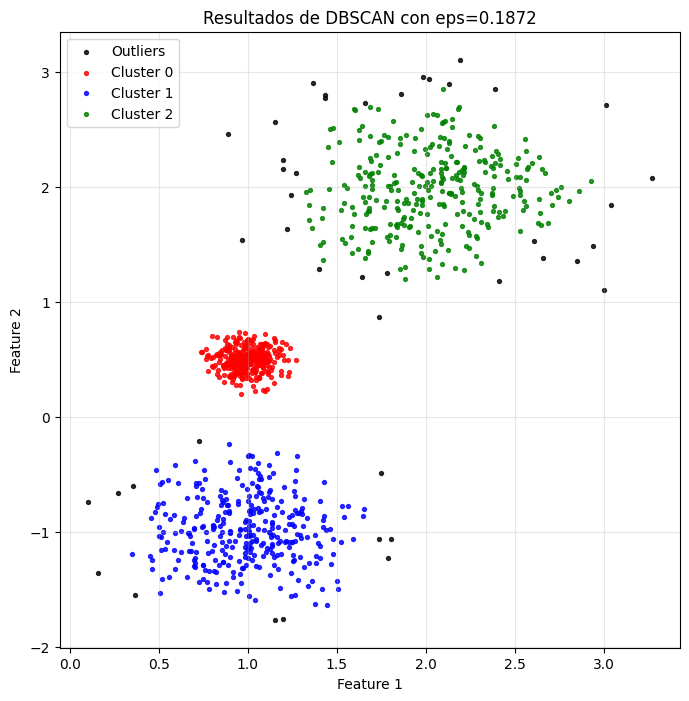

In [ ]:
# Ajustar DBSCAN con el eps óptimo encontrado
e = 0.1872
db = DBSCAN(eps=e, min_samples=10).fit(X)
labels = db.labels_

# Crear la figura
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)

# Definir colores para los clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'yellow', 'magenta', 'brown', 'gray', 'black']

# Graficar los datos según sus etiquetas
for cluster_id in np.unique(labels):
    mask = labels == cluster_id
    if cluster_id == -1:
        color = 'black'
        label = 'Outliers'
    else:
        color = colors[cluster_id % len(colors)]
        label = f'Cluster {cluster_id}'

    ax.scatter(X[mask, 0], X[mask, 1],
               c=color,
               label=label,
               s=8, alpha=0.8)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title(f'Resultados de DBSCAN con eps={e}')
ax.legend()
ax.grid(alpha=0.3)

plt.show()

Podemos ver que tenemos una estimación razonable de la agrupación real. Esto suele ser suficiente para el trabajo de investigación. Si la inexistencia de valores atípicos es una suposición intuitiva para el escenario, uno puede simplemente usar los vecinos más cercanos calculados para reasignar los puntos atípicos (denominados como grupo - 1) a los grupos detectados.

Hay algunas suposiciones implícitas en este enfoque:

- Las densidades en todos los grupos son las mismas.
- Los tamaños de los conglomerados o las desviaciones estándar son los mismos.

Estas suposiciones están implícitas cuando consideramos el mismo nivel de vecino para el cálculo del punto de codo. Sin embargo, en los datos originales, podemos ver claramente que las densidades no son las mismas. Esta es la razón principal por la que observamos algunos valores atípicos a pesar de que los puntos se distribuyen utilizando una desviación estándar fija.

## <font color='green'>Actividad 3</font>

El archivo multishape.csv es un dataset sintético muy utilizado en enseñanza de Machine Learning no supervisado (clustering), especialmente para demostrar algoritmos que detectan formas no esféricas como DBSCAN o Spectral Clustering.
Aplicar el algoritmo DBSCAN sobre los datos del archivo.

1. Calcular las métricas de calidad de clusters: de homogeneidad, completitud, y mean silhouette score.

2. Seleccionar los mejores parámetros (eps, min_sample) según los puntajes de calidad del clúster.

3. Utilice el algoritmo de punto codo para encontrar sus hiperparámetros. Compare con los resultados del punto 3.


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/08_Introduccion_Machine_Learning/multishape.csv')
df.head()

,x,y,shape
0,-0.803739,-0.853053,1
1,0.852851,0.367618,1
2,0.927180,-0.274902,1
3,-0.752626,-0.511565,1
4,0.706846,0.810679,1


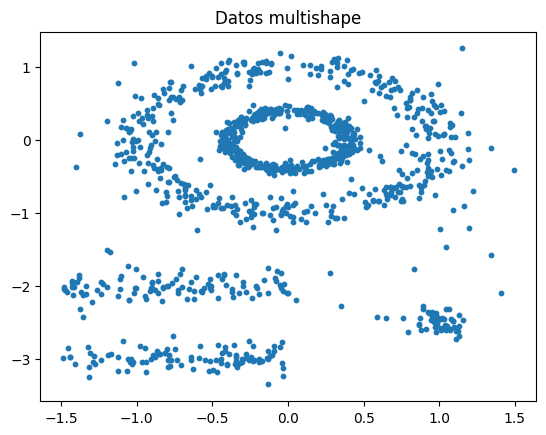

In [ ]:
# Tu código aquí ...

# Cargar datos
X = df[['x', 'y']].values  # Seleccionar las coordenadas x e y

# Visualización inicial
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title("Datos multishape")
plt.show()


In [ ]:
# Escalamiento de datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


Número de clusters: 5
Homogeneidad: 0.20
Completitud: 1.00
Silhouette Score: 0.21


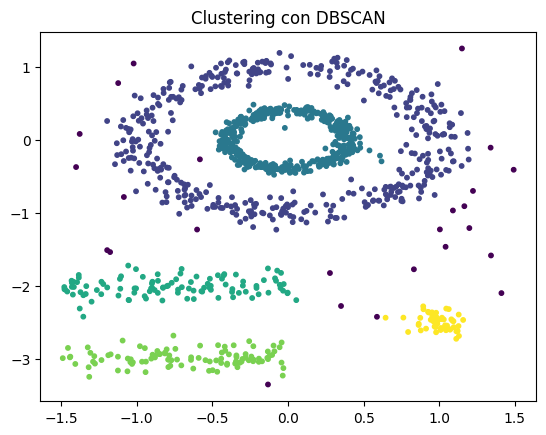

In [ ]:
# Parámetros iniciales de DBSCAN
eps = 0.2
min_samples = 5

# Aplicar DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Calcular las métricas
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
homogeneity = metrics.homogeneity_score(df['x'], dbscan_labels)
completeness = metrics.completeness_score(df['x'], dbscan_labels)
silhouette = metrics.silhouette_score(X_scaled, dbscan_labels) if n_clusters > 1 else -1

# Imprimir métricas
print(f"Número de clusters: {n_clusters}")
print(f"Homogeneidad: {homogeneity:.2f}")
print(f"Completitud: {completeness:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")

# Visualizar clusters
plt.scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title("Clustering con DBSCAN")
plt.show()

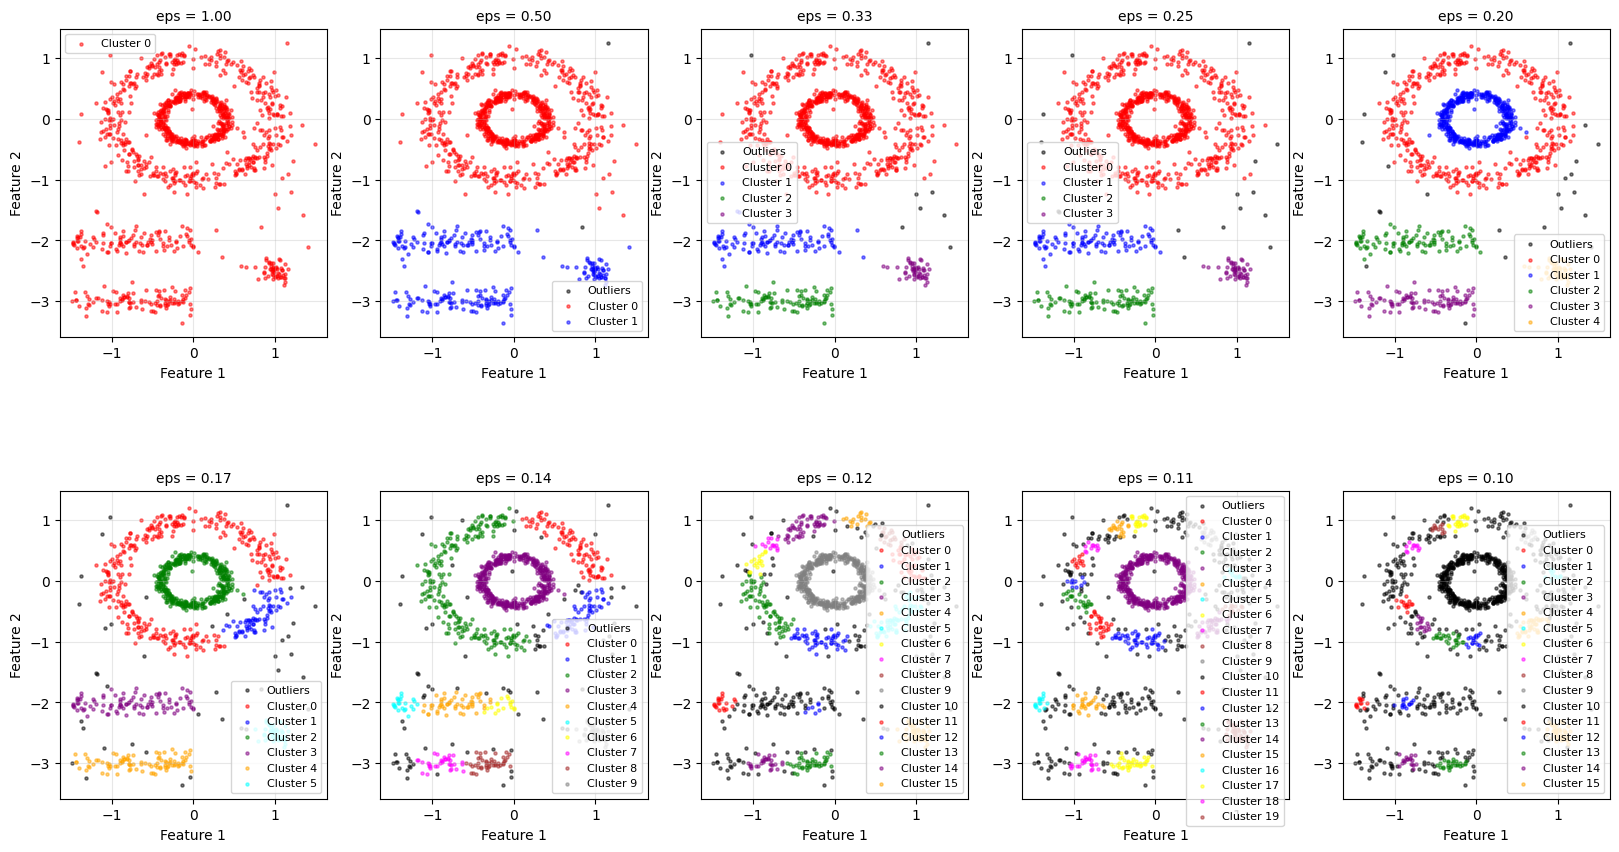

In [ ]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

i = 1
for x in range(10, 0, -1):
    eps = 1 / (11 - x)
    db = DBSCAN(eps=eps, min_samples=10).fit(X)
    labels = db.labels_

    ax = fig.add_subplot(2, 5, i)
    ax.set_title(f"eps = {eps:.2f}", fontsize=10)

    for cluster_id in np.unique(labels):
        mask = labels == cluster_id
        if cluster_id == -1:
            color = 'black'
            label = 'Outliers'
        else:
            color = colors[cluster_id % len(colors)]
            label = f'Cluster {cluster_id}'

        ax.scatter(X[mask, 0], X[mask, 1],
                   c=color,
                   label=label,
                   s=5, alpha=0.5)

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

    i += 1

plt.show()

Vemos que los hiperparametros que dan mejor resultado de clusterizacion es el de eps = 0.2.

A continuación lo estimamos econ el método del codo:

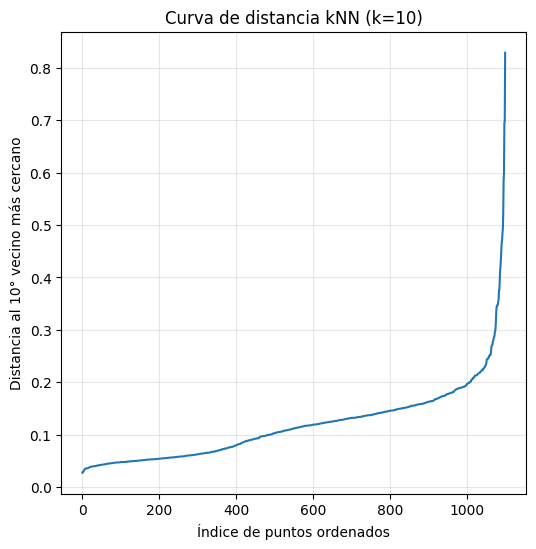

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Ajustar el modelo de vecinos más cercanos
# Solicitamos 11 vecinos porque el primer vecino siempre es el propio punto
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(X)

# Obtener distancias y los índices de los vecinos
distances, indices = neighbors.kneighbors(X)

# Nos interesa la distancia al 10° vecino real (no al propio punto)
distances = np.sort(distances[:, 10], axis=0)

# Crear la figura
fig = plt.figure(figsize=(6, 6))
plt.plot(distances)
plt.xlabel("Índice de puntos ordenados")
plt.ylabel("Distancia al 10° vecino más cercano")
plt.title("Curva de distancia kNN (k=10)")
plt.grid(alpha=0.3)
plt.show()

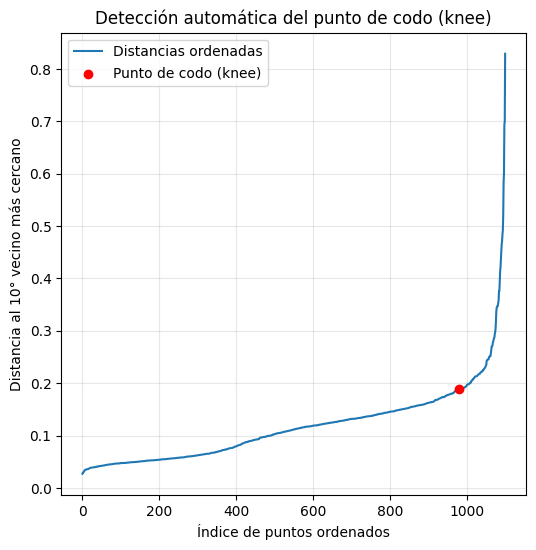


Distancia óptima sugerida (eps): 0.1882


In [ ]:
# Calcular el "knee point" automáticamente
i = np.arange(len(distances))
knee = KneeLocator(
    x=i,
    y=distances,
    S=1,                     # Sensibilidad del algoritmo (valor típico)
    curve='convex',           # Forma esperada de la curva
    direction='increasing',   # La curva crece
    interp_method='polynomial'  # Método de interpolación para suavizar
)

# Crear la figura
plt.figure(figsize=(6, 6))
plt.plot(i, distances, label='Distancias ordenadas')
plt.scatter(knee.knee, distances[knee.knee], color='red', label='Punto de codo (knee)', zorder=5)
plt.xlabel("Índice de puntos ordenados")
plt.ylabel("Distancia al 10° vecino más cercano")
plt.title("Detección automática del punto de codo (knee)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Imprimir la distancia correspondiente al knee detectado
print(f"\nDistancia óptima sugerida (eps): {distances[knee.knee]:.4f}")

Según este metodo, nos indica que el mejor hiperparámetros es eps = 0.1882, valor muy cercano al que vimos visualmente en (0.2)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


Número de clusters: 5
Homogeneidad: 0.20
Completitud: 1.00
Silhouette Score: 0.21


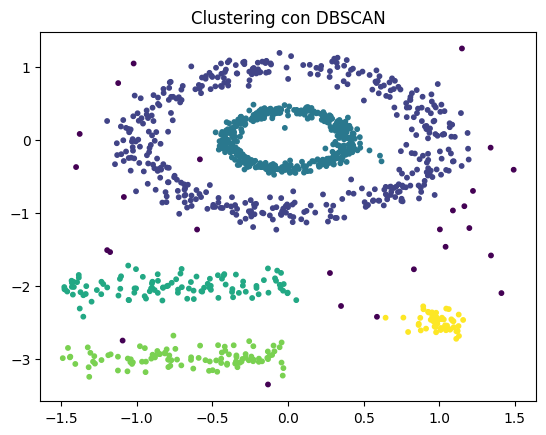

In [ ]:
# Parámetros iniciales de DBSCAN
eps = 0.1882
min_samples = 5

# Aplicar DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Calcular las métricas
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
homogeneity = metrics.homogeneity_score(df['x'], dbscan_labels)
completeness = metrics.completeness_score(df['x'], dbscan_labels)
silhouette = metrics.silhouette_score(X_scaled, dbscan_labels) if n_clusters > 1 else -1

# Imprimir métricas
print(f"Número de clusters: {n_clusters}")
print(f"Homogeneidad: {homogeneity:.2f}")
print(f"Completitud: {completeness:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")

# Visualizar clusters
plt.scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title("Clustering con DBSCAN")
plt.show()

<font color='green'>Fin Actividad 3</font>


# <font color='red'> EXPERIMENTO 2: Clustering Jerárquico con Enfoque en Variables Socioeconómicas Objetivo </font>

Este segundo experimento utilizará clustering jerárquico para identificar patrones socioeconómicos entre los pasajeros del Titanic y determinar si estos patrones tienen relación con la supervivencia.
1. **Preparación de datos:**
    * Trabajo con variables numéricas (Age, Fare, SibSp, Parch)
    * Crear nuevas variables derivadas:
        * Ratio de tarifa por clase (Fare/Pclass)
        * Variable binaria para viajeros solitarios (Alone = 1 if SibSp+Parch = 0 else 0)
    * Normalizar todas las variables numéricas
    * Manejar valores faltantes con imputación por la mediana
2. **Implementación:**
    * Aplicar clustering jerárquico aglomerativo usando diferentes métricas de distancia (euclidiana, Manhattan)
    * Utilizar diferentes métodos de enlace (Ward, completo, promedio)
    * Determinar el número óptimo de clusters utilizando el dendrograma y la métrica de silueta
3. **Visualización y análisis:**
    * Crear un dendrograma para visualizar la jerarquía de clusters
    * Generar gráficos de dispersión con los clusters coloreados para diferentes pares de variables
    * Crear una tabla de contingencia que muestre la distribución de supervivencia por cluster
    * Utilizar gráficos de radar para visualizar las características de cada cluster


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm

# Preprocesamiento
df = train_df.copy()
df['Fare_per_class'] = df['Fare'] / df['Pclass']
df['Alone'] = ((df['SibSp'] + df['Parch']) == 0).astype(int)

# Imputar valores faltantes
df['Age'].fillna(df['Age'].median(), inplace=True)

# Seleccionar variables para clustering
X = df[['Age', 'Fare', 'SibSp', 'Parch', 'Fare_per_class', 'Alone']]

# Normalizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<ipython-input-6-7bd5ccc36628>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)


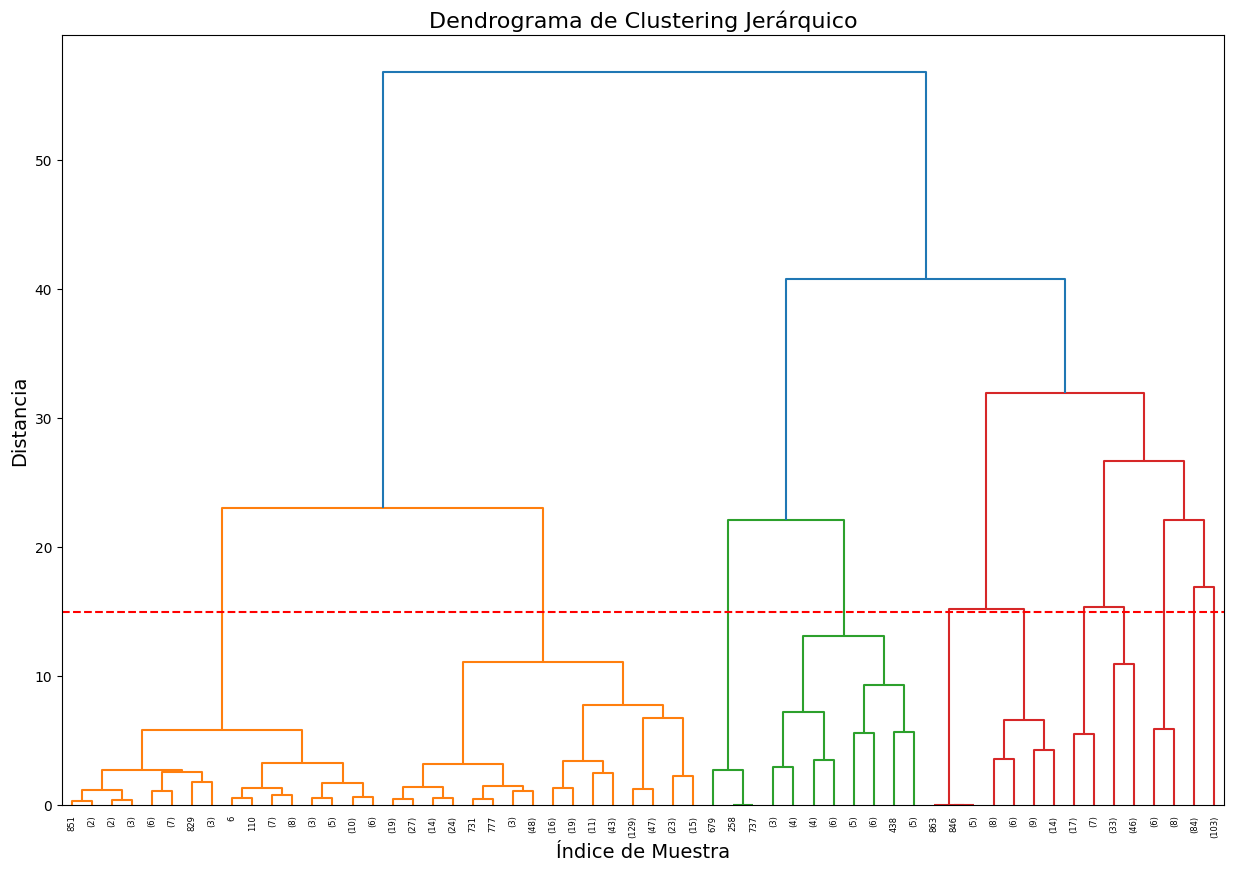

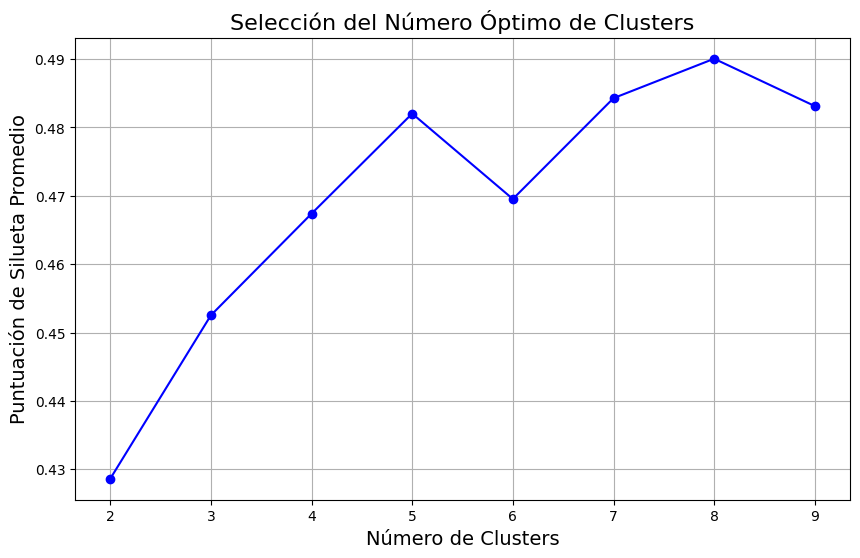

In [7]:
# 1. Visualización del Dendrograma
plt.figure(figsize=(15, 10))
linkage_matrix = linkage(X_scaled, method='ward')
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Dendrograma de Clustering Jerárquico', fontsize=16)
plt.xlabel('Índice de Muestra', fontsize=14)
plt.ylabel('Distancia', fontsize=14)
plt.axhline(y=15, color='r', linestyle='--')  # Línea sugerida para corte
plt.savefig('dendrograma.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Determinar número óptimo de clusters usando silhouette score
silhouette_avg = []
for n_clusters in range(2, 10):
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = clusterer.fit_predict(X_scaled)
    silhouette_avg.append(silhouette_score(X_scaled, cluster_labels))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_avg, 'bo-')
plt.xlabel('Número de Clusters', fontsize=14)
plt.ylabel('Puntuación de Silueta Promedio', fontsize=14)
plt.title('Selección del Número Óptimo de Clusters', fontsize=16)
plt.grid(True)
plt.savefig('silhouette_score.png', dpi=300, bbox_inches='tight')
plt.show()


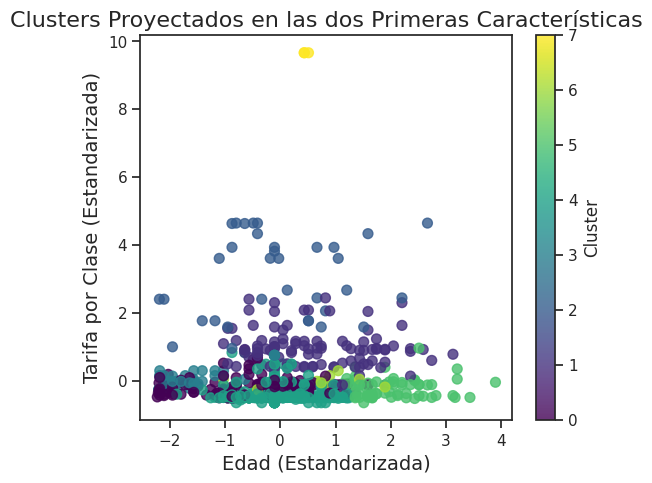

In [14]:
# 3. Aplicar clustering con el número óptimo de clusters 8
n_clusters = 8
cluster_model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df['Cluster'] = cluster_model.fit_predict(X_scaled)

# 4. Visualización scatter plot de los clusters
plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1],
                      c=df['Cluster'], cmap='viridis',
                      s=50, alpha=0.8)
plt.colorbar(scatter, label='Cluster')
plt.title('Clusters Proyectados en las dos Primeras Características', fontsize=16)
plt.xlabel('Edad (Estandarizada)', fontsize=14)
plt.ylabel('Tarifa por Clase (Estandarizada)', fontsize=14)
plt.savefig('scatter_clusters.png', dpi=300, bbox_inches='tight')
plt.show()


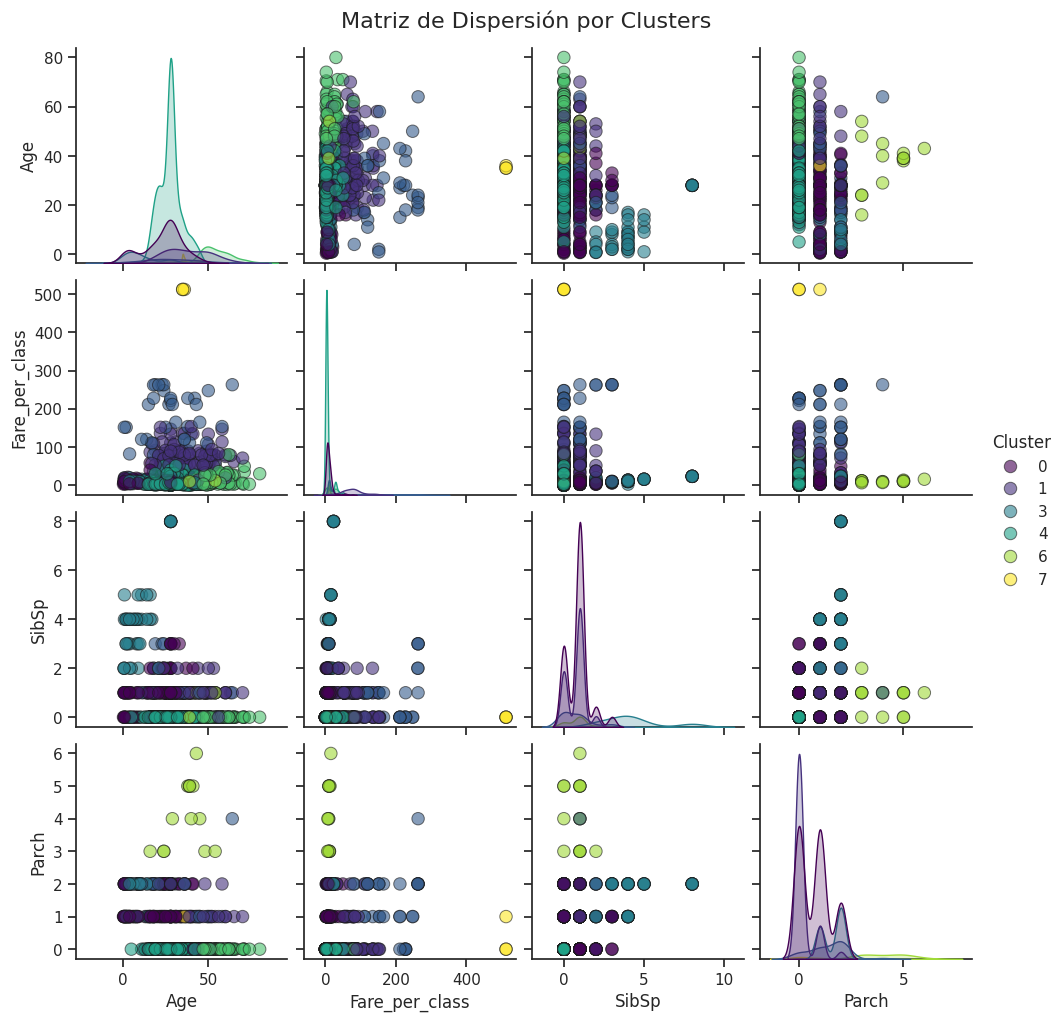

In [15]:
# 5. Matriz de dispersión coloreada por cluster
sns.set(style="ticks")
vars_to_plot = ['Age', 'Fare_per_class', 'SibSp', 'Parch']
sns.pairplot(df[vars_to_plot + ['Cluster']],
             hue='Cluster',
             palette='viridis',
             diag_kind='kde',
             plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height=2.5)
plt.suptitle('Matriz de Dispersión por Clusters', y=1.02, fontsize=16)
plt.savefig('pairplot_clusters.png', dpi=300, bbox_inches='tight')
plt.show()


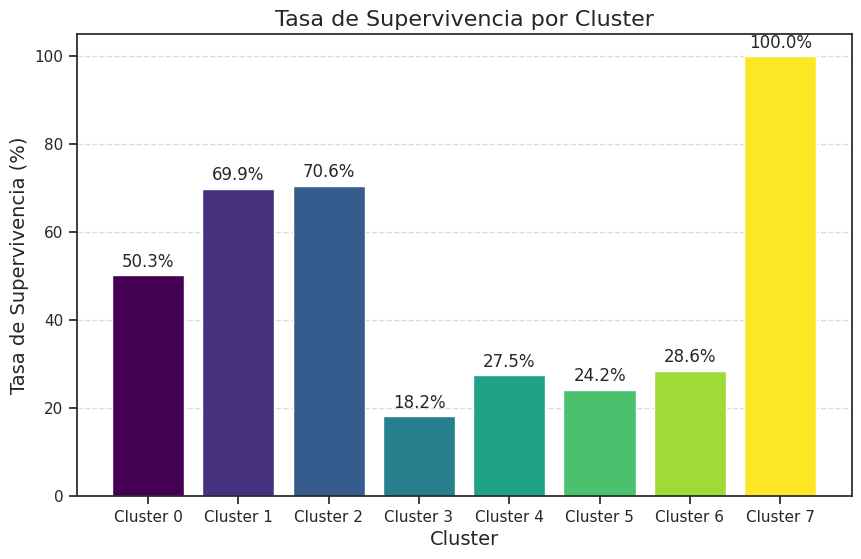

In [16]:
# 6. Visualizar la tasa de supervivencia por cluster
survival_by_cluster = pd.crosstab(df['Cluster'], df['Survived'])
survival_rate = (survival_by_cluster[1] / (survival_by_cluster[0] + survival_by_cluster[1])) * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(range(n_clusters), survival_rate, color=plt.cm.viridis(np.linspace(0, 1, n_clusters)))
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Tasa de Supervivencia (%)', fontsize=14)
plt.title('Tasa de Supervivencia por Cluster', fontsize=16)
plt.xticks(range(n_clusters), [f'Cluster {i}' for i in range(n_clusters)])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir etiquetas de porcentaje
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=12)

plt.savefig('survival_rate.png', dpi=300, bbox_inches='tight')
plt.show()


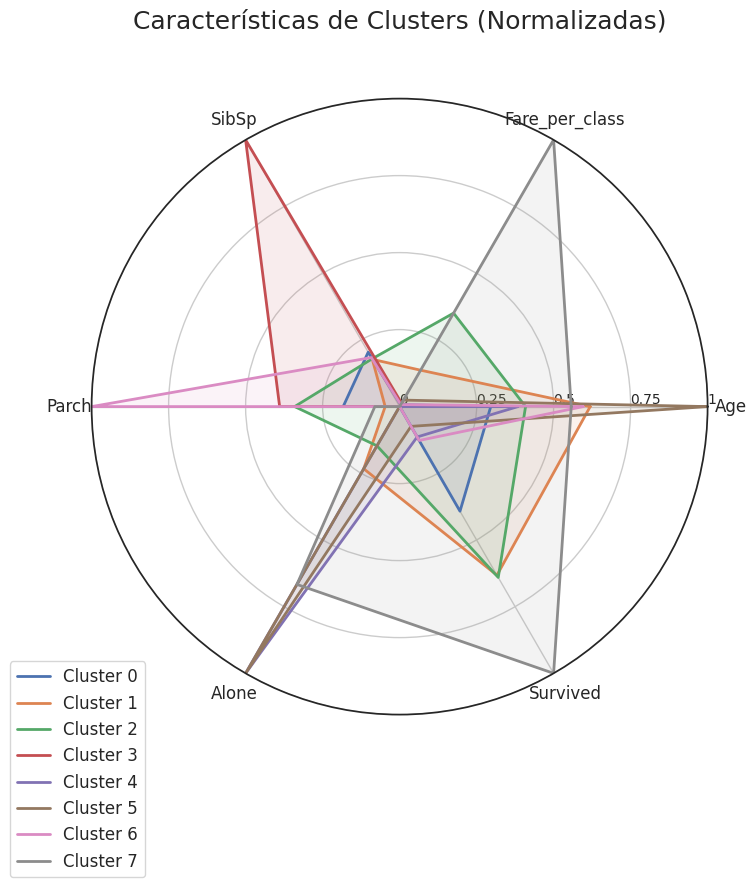

In [19]:
# 7. Gráfico de radar para comparar características de clusters
# Calcular medias por cluster
cluster_means = df.groupby('Cluster')[['Age', 'Fare_per_class', 'SibSp', 'Parch', 'Alone', 'Survived']].mean()

# Normalizar las medias para el gráfico radar
radar_df = cluster_means.copy()
for col in radar_df.columns:
    radar_df[col] = (radar_df[col] - radar_df[col].min()) / (radar_df[col].max() - radar_df[col].min())

# Configurar el gráfico de radar
categories = list(radar_df.columns)
N = len(categories)

# Crear figura
fig = plt.figure(figsize=(12, 8))

# Crear ángulos para cada variable
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Cerrar el círculo

# Inicializar el gráfico
ax = plt.subplot(111, polar=True)

# Añadir cada cluster
for i in range(n_clusters):
    values = radar_df.iloc[i].values.tolist()
    values += values[:1]  # Cerrar el círculo
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

# Estilos el gráfico
plt.xticks(angles[:-1], categories, size=12)
ax.set_rlabel_position(0)
plt.yticks([0, 0.25, 0.5, 0.75, 1], ["0", "0.25", "0.5", "0.75", "1"], size=10)
plt.ylim(0, 1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)
plt.title('Características de Clusters (Normalizadas)', size=18, y=1.1)

plt.savefig('radar_chart.png', dpi=300, bbox_inches='tight')
plt.show()


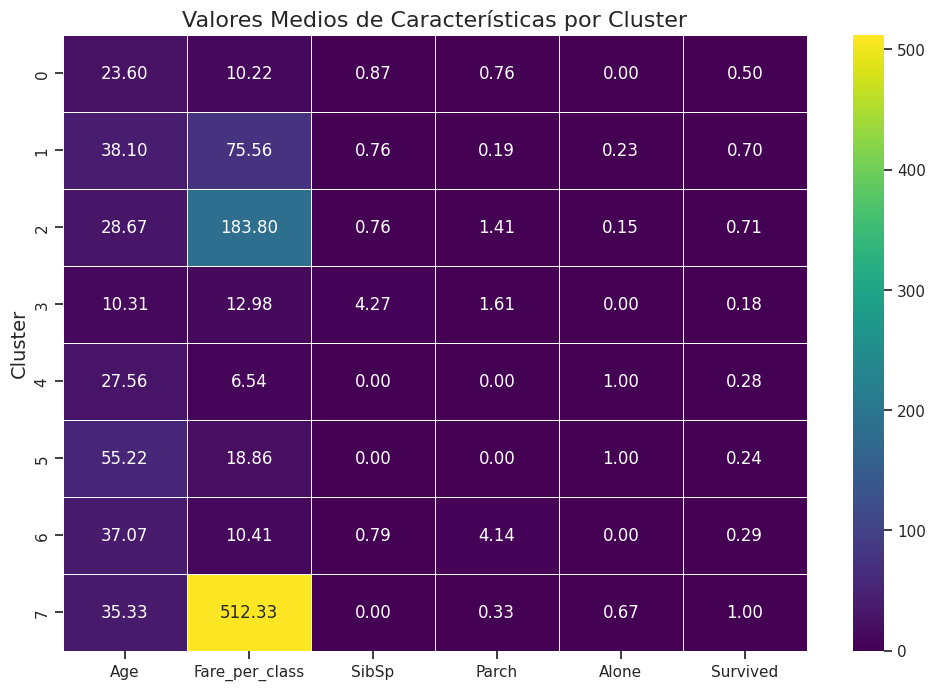

In [20]:
# 8. Mapa de calor de características medias por cluster
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('Valores Medios de Características por Cluster', fontsize=16)
plt.ylabel('Cluster', fontsize=14)
plt.savefig('heatmap_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# 9. Resumen de características principales por cluster
print("Resumen de características por cluster:")
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    cluster_data = df[df['Cluster'] == i]

    # Tamaño del cluster
    print(f"Número de pasajeros: {len(cluster_data)} ({len(cluster_data)/len(df)*100:.1f}%)")

    # Tasa de supervivencia
    surv_rate = cluster_data['Survived'].mean() * 100
    print(f"Tasa de supervivencia: {surv_rate:.1f}%")

    # Distribución de clase
    class_dist = cluster_data['Pclass'].value_counts(normalize=True) * 100
    print("Distribución por clase:")
    for pclass, pct in class_dist.items():
        print(f"  - Clase {pclass}: {pct:.1f}%")

    # Características demográficas
    print(f"Edad promedio: {cluster_data['Age'].mean():.1f} años")
    print(f"Tarifa promedio: £{cluster_data['Fare'].mean():.2f}")
    print(f"Viajando solo: {cluster_data['Alone'].mean()*100:.1f}%")
    print(f"Número promedio de familiares: {(cluster_data['SibSp'] + cluster_data['Parch']).mean():.2f}")

    # Género
    gender_dist = cluster_data['Sex'].value_counts(normalize=True) * 100
    print("Distribución por género:")
    for gender, pct in gender_dist.items():
        print(f"  - {gender.capitalize()}: {pct:.1f}%")

Resumen de características por cluster:

Cluster 0:
Número de pasajeros: 187 (21.0%)
Tasa de supervivencia: 50.3%
Distribución por clase:
  - Clase 3: 59.9%
  - Clase 2: 35.3%
  - Clase 1: 4.8%
Edad promedio: 23.6 años
Tarifa promedio: £21.08
Viajando solo: 0.0%
Número promedio de familiares: 1.63
Distribución por género:
  - Female: 52.9%
  - Male: 47.1%

Cluster 1:
Número de pasajeros: 103 (11.6%)
Tasa de supervivencia: 69.9%
Distribución por clase:
  - Clase 1: 89.3%
  - Clase 2: 9.7%
  - Clase 3: 1.0%
Edad promedio: 38.1 años
Tarifa promedio: £77.87
Viajando solo: 23.3%
Número promedio de familiares: 0.95
Distribución por género:
  - Female: 58.3%
  - Male: 41.7%

Cluster 2:
Número de pasajeros: 34 (3.8%)
Tasa de supervivencia: 70.6%
Distribución por clase:
  - Clase 1: 100.0%
Edad promedio: 28.7 años
Tarifa promedio: £183.80
Viajando solo: 14.7%
Número promedio de familiares: 2.18
Distribución por género:
  - Female: 61.8%
  - Male: 38.2%

Cluster 3:
Número de pasajeros: 44 (4.9%)

<font color='red'>Fin Experimento 2